In [1]:
# imports libraries + project modules
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# plotting and tsv 
import TsvMapHelperFunctions as helper
#genome loading/guide mapping
import postprocessHelpers as php

In [2]:
# Load genome sequence from FASTA file
from Bio import SeqIO

genome_fasta = 'cJP003_assembly.fasta'  # or your genome filename
genome_sequence = str(next(SeqIO.parse(genome_fasta, "fasta")).seq).upper()

print(f"Genome loaded: {len(genome_sequence)} bp")

Genome loaded: 4634619 bp


In [3]:
# Bulk configuration: discover TSVs and set output directory
from pathlib import Path
import re
import pandas as pd

# Folder containing TSVs (relative to notebook, or set absolute path)
input_tsv_dir = Path("combined_R1_tsv_files")

# Where to write per-sample CSV outputs (change this)
output_csv_dir = Path("/Users/ecreed/Desktop/KelloggRotation/02052026_TagmentatioAnalysis_251218_260117_260203_combined/FilteredCandidateSpacersBulk")
output_csv_dir.mkdir(parents=True, exist_ok=True)

# Discover TSV files following: {i}_S{i}_L001_R1_001.insertions.5p.tsv
tsv_files = sorted(
    input_tsv_dir.glob("*_S*_L001_R1_001.insertions.5p.tsv"),
    key=lambda p: int(re.match(r"(\d+)_S\1_", p.name).group(1)) if re.match(r"(\d+)_S\1_", p.name) else p.name
)

print(f"Found {len(tsv_files)} TSV files in {input_tsv_dir}")

# Load guide RNA info (must align 1:1 with tsv_files ordering/indexing)
guideRNA = pd.read_csv("FinalGuides_251218_260117_260203_combined.csv")

# Filters / knobs used elsewhere (do not change processing logic below)
min_mapq = 30


Found 120 TSV files in combined_R1_tsv_files


In [4]:
window_bp = 200

def percent_within_distance(insertions, target_position, window_bp):
    
    if len(insertions) == 0:
        return 0.0
    
    count_within = sum(
        abs(pos - target_position) <= window_bp
        for pos in insertions
    )
    
    return 100.0 * count_within / len(insertions)

In [5]:
# find PAM and making new sgRNA sequences

from typing import List, Dict

def find_pam_and_generate_sgrna(
    genome_seq: str,
    alignment_start: int,
    alignment_end: int,
    best_strand: str,
    window_bp: int = 25,
    pam_motif: str = "NGG",
    spacer_len: int = 20,
) -> list[dict]:
    """
    Find PAM sites in a window around guide alignment and generate sgRNA sequences.
    """
    alignment_center = (alignment_start + alignment_end) // 2
    search_start = max(0, alignment_center - window_bp)
    search_end = min(len(genome_seq), alignment_center + window_bp)
    window_seq = genome_seq[search_start:search_end]
    
    results = []
    
    pam_hits = php.extract_spacers(  # <-- use php prefix
        window_seq,
        pam_motif,
        spacer_len=spacer_len,
        spacer_side="5prime",
        search_strands="both"
    )
    
    for hit in pam_hits:
        pam_start_genomic = search_start + hit.pam_start
        pam_end_genomic = search_start + hit.pam_end
        spacer_start_genomic = search_start + hit.spacer_start
        spacer_end_genomic = search_start + hit.spacer_end
        
        if pam_end_genomic <= alignment_start:
            distance = alignment_start - pam_end_genomic
            position_rel = "upstream"
        elif pam_start_genomic >= alignment_end:
            distance = pam_start_genomic - alignment_end
            position_rel = "downstream"
        else:
            distance = 0
            position_rel = "overlapping"
        
        spacer_seq = genome_seq[spacer_start_genomic:spacer_end_genomic]
        
        results.append({
            'pam_start': pam_start_genomic,
            'pam_end': pam_end_genomic,
            'spacer_start': spacer_start_genomic,
            'spacer_end': spacer_end_genomic,
            'pam_seq': hit.pam_dna,
            'spacer_seq': spacer_seq,
            'strand': hit.strand,
            'distance_to_alignment': distance,
            'position_relative_to_alignment': position_rel,
        })
    
    results.sort(key=lambda x: x['distance_to_alignment'])
    return results

In [6]:
# v4 csv output, target site fixed
# v3 single csv, calculate integration freq from cluster
# filtered candidate spacers single csv with insertion strand distribution and frequency columns 
# bulk run + filtering by NGG and distance
# Bulk: write per-sample CSVs but only include NGG guides 66-76 bp from their mcv
# ENHANCED: add strand distribution and hotspot frequency columns
# FIXED: integration_frequency now sums across all cluster members, not just rep_pos

import re
import pandas as pd
from collections import Counter
from pathlib import Path

def revcomp(seq):
    comp = str.maketrans("ACGTacgt", "TGCAtgca")
    return seq.translate(comp)[::-1]

def _sample_id_from_name(p: Path):
    m = re.match(r"(\d+)_S\1_", p.name)
    return int(m.group(1)) if m else None

written = []
skipped = []
all_rows = []

for nn, tsv_path in enumerate(tsv_files):
    sample_id = _sample_id_from_name(tsv_path) or (nn + 1)

    # load + basic filter (min_mapq expected in notebook)
    tsv = pd.read_csv(tsv_path, sep="\t")
    tsv = tsv[tsv["mapq"] >= min_mapq]
    
    # Calculate total insertions in sample and strand counts per insertion position
    total_insertions = len(tsv)
    insertion_strands = {}  # {position: {'+': count, '-': count}}
    for _, row in tsv.iterrows():
        pos = row["ins0"]
        strand = row.get("strand", "+")  # default to + if not present
        if pos not in insertion_strands:
            insertion_strands[pos] = {'+': 0, '-': 0}
        insertion_strands[pos][strand] = insertion_strands[pos].get(strand, 0) + 1

    # collapse hotspots (same logic as before)
    collapse_bp = 5
    min_reads = 500

    counts = Counter(tsv["ins0"])
    gmap = php.map_guide_to_genome(guideRNA["protospacer"][nn], genome_sequence)
    target_guide_start = gmap[0]["start"]
    target_strand = gmap[0]["strand"]
    if target_strand == "+":
        target_insertion_site = target_guide_start + 20 + 2 + 71
    else:
        target_insertion_site = target_guide_start - 2 - 71
    counts[target_insertion_site] = counts.get(target_insertion_site, 0)

    clusters = [{"members": {pos: freq}, "total": freq} for pos, freq in counts.items()]
    merged = True
    while merged:
        merged = False
        new_clusters = []
        while clusters:
            c = clusters.pop(0)
            i = 0
            while i < len(clusters):
                other = clusters[i]
                close = any(abs(p - q) <= collapse_bp for p in c["members"] for q in other["members"])
                if close:
                    for p, f in other["members"].items():
                        c["members"][p] = c["members"].get(p, 0) + f
                    c["total"] += other["total"]
                    clusters.pop(i)
                    merged = True
                else:
                    i += 1
            new_clusters.append(c)
        clusters = new_clusters

    clusters_info = []
    for c in clusters:
        rep_pos, rep_count = max(c["members"].items(), key=lambda x: x[1])
        clusters_info.append({
            "rep_pos": int(rep_pos),
            "rep_count": int(rep_count),
            "total": int(c["total"]),
            "members": sorted(c["members"].keys()),
            "contains_target": (target_insertion_site in c["members"])
        })

    filtered = [c for c in clusters_info if c["total"] > min_reads]
    if not any(c["contains_target"] for c in filtered):
        for c in clusters_info:
            if c["contains_target"]:
                filtered.append(c)
                break

    filtered.sort(key=lambda x: x["total"], reverse=True)
    for idx, c in enumerate(filtered, start=1):
        c["mcv_id"] = idx

    # Build a lookup: rep_pos -> cluster info (for fast integration frequency calculation)
    cluster_lookup = {c["rep_pos"]: c for c in filtered}

    mcv_list = [c["rep_pos"] for c in filtered]
    hotspots = {f"mcv{idx}": pos for idx, pos in enumerate(mcv_list, start=1)}
    for idx, pos in enumerate(mcv_list, start=1):
        globals()[f"mcv{idx}"] = pos

    # Generate guides (methods 1,2,3) exactly as before
    original_guide = guideRNA["protospacer"][nn]
    hotspots_dict = hotspots if (isinstance(hotspots, dict) and hotspots) else ({f"mcv{i+1}": pos for i,pos in enumerate(mcv_list)} if "mcv_list" in globals() else {})
    _alignment_ctx = {}
    for hotspot_name, insertion_site in hotspots_dict.items():
        window_start = max(0, insertion_site - 120)
        window_end = min(len(genome_sequence), insertion_site + 120)
        window_seq = genome_sequence[window_start:window_end]

        aln_fwd = php.local_align(original_guide, window_seq)
        aln_rev = php.local_align(original_guide, revcomp(window_seq))

        if aln_fwd.score >= aln_rev.score:
            best_aln = aln_fwd
            best_strand = "+"
            search_seq = window_seq
        else:
            best_aln = aln_rev
            best_strand = "-"
            search_seq = revcomp(window_seq)

        _alignment_ctx[hotspot_name] = {
            "insertion_site": insertion_site,
            "window_start": window_start,
            "window_end": window_end,
            "window_seq": window_seq,
            "best_aln": best_aln,
            "best_strand": best_strand,
            "search_seq": search_seq,
        }

    rows = []

    window_radius = 120
    # Method 1
    for hotspot_name, insertion_site in hotspots_dict.items():
        win_start = max(0, insertion_site - window_radius)
        win_end = min(len(genome_sequence), insertion_site + window_radius)
        win_seq = genome_sequence[win_start:win_end]

        for i in range(len(win_seq) - 2):
            pam = win_seq[i:i+3]
            if pam[1:3] == "GG":
                pam_genomic_start = win_start + i
                pam_genomic_end = pam_genomic_start + 3
                guide_start = pam_genomic_start - 20
                guide_end = pam_genomic_start
                if guide_start < 0:
                    continue
                guide_seq = genome_sequence[guide_start:guide_end]
                dist = abs((pam_genomic_end - 1) - insertion_site)
                try:
                    aln_score = php.local_align(original_guide, guide_seq).score
                except Exception:
                    aln_score = None
                mismatch_count = sum(a != b for a, b in zip(original_guide, guide_seq))
                rows.append({
                    "hotspot": hotspot_name,
                    "method": 1,
                    "pam_type": "NGG",
                    "pam_seq": pam,
                    "guide_seq": guide_seq,
                    "guide_start": int(guide_start),
                    "guide_end": int(guide_end),
                    "strand": "+",
                    "mismatch_count": int(mismatch_count),
                    "alignment_score": aln_score,
                    "distance_to_mcv": int(dist),
                    "insertion_site": int(insertion_site)
                })

        for i in range(len(win_seq) - 2):
            motif = win_seq[i:i+3]
            if motif[0:2] == "CC":
                pam_genomic_start = win_start + i
                pam_genomic_end = pam_genomic_start + 3
                guide_start = pam_genomic_end
                guide_end = guide_start + 20
                if guide_end > len(genome_sequence):
                    continue
                guide_seq = revcomp(genome_sequence[guide_start:guide_end])
                dist = abs(pam_genomic_start - insertion_site)
                try:
                    aln_score = php.local_align(original_guide, guide_seq).score
                except Exception:
                    aln_score = None
                mismatch_count = sum(a != b for a, b in zip(original_guide, guide_seq))
                rows.append({
                    "hotspot": hotspot_name,
                    "method": 1,
                    "pam_type": "NGG",
                    "pam_seq": revcomp(motif),
                    "guide_seq": guide_seq,
                    "guide_start": int(guide_start),
                    "guide_end": int(guide_end),
                    "strand": "-",
                    "mismatch_count": int(mismatch_count),
                    "alignment_score": aln_score,
                    "distance_to_mcv": int(dist),
                    "insertion_site": int(insertion_site)
                })

    # Method 2
    for hotspot_name, ctx in _alignment_ctx.items():
        insertion_site = ctx["insertion_site"]
        window_start = ctx["window_start"]
        window_seq = ctx["window_seq"]
        best_aln = ctx["best_aln"]
        best_strand = ctx["best_strand"]
        search_seq = ctx["search_seq"]

        target_coords = best_aln.coordinates[1]
        target_start = int(target_coords[0])
        target_end = int(target_coords[-1])

        if best_strand == "+":
            genomic_start = window_start + target_start
            genomic_end = window_start + target_end
        else:
            genomic_start = window_start + (len(window_seq) - target_end)
            genomic_end = window_start + (len(window_seq) - target_start)

        coords_q = best_aln.coordinates[0]
        coords_t = best_aln.coordinates[1]

        query_seq = best_aln.query
        target_seq = best_aln.target

        first_match_query_pos = None
        first_match_target_pos = None
        query_pos = 0
        target_pos = 0
        for q, t in zip(query_seq, target_seq):
            if q != "-" and t != "-" and q == t:
                first_match_query_pos = query_pos
                first_match_target_pos = target_pos
                break
            if q != "-":
                query_pos += 1
            if t != "-":
                target_pos += 1

        if first_match_query_pos is not None:
            first_match_genomic = genomic_start + first_match_target_pos
            new_guide_start = first_match_genomic - first_match_query_pos
            new_guide_end = new_guide_start + 20
            if 0 <= new_guide_start and new_guide_end <= len(genome_sequence):
                if best_strand == "+":
                    new_guide = genome_sequence[new_guide_start:new_guide_end]
                    new_guide_gstart = new_guide_start
                    new_guide_gend = new_guide_end
                else:
                    new_guide = revcomp(genome_sequence[new_guide_start:new_guide_end])
                    new_guide_gstart = new_guide_start
                    new_guide_gend = new_guide_end

                if best_strand == "+":
                    five_prime_start = target_start - 3
                    five_prime_end = target_start
                    five_prime_seq = window_seq[five_prime_start:five_prime_end] if five_prime_start >= 0 else ""
                    distance_to_mcv = abs(new_guide_gstart - insertion_site)
                else:
                    five_prime_start = target_end
                    five_prime_end = target_end + 3
                    five_prime_seq = revcomp(window_seq)[five_prime_start:five_prime_end] if five_prime_end <= len(window_seq) else ""
                    distance_to_mcv = abs(new_guide_gend - insertion_site)

                pam_type = None
                pam_seq = five_prime_seq
                if len(pam_seq) == 3:
                    if pam_seq[1:3] == "GG":
                        pam_type = "NGG"
                    elif pam_seq[1:3] == "AG":
                        pam_type = "NAG"
                    elif pam_seq[1:3] == "GA":
                        pam_type = "NGA"

                if pam_type:
                    mismatch_count = sum(a != b for a, b in zip(original_guide, new_guide))
                    try:
                        aln_score = php.local_align(original_guide, new_guide).score
                    except Exception:
                        aln_score = None

                    rows.append({
                        "hotspot": hotspot_name,
                        "method": 2,
                        "pam_type": pam_type,
                        "pam_seq": pam_seq,
                        "guide_seq": new_guide,
                        "guide_start": int(new_guide_gstart),
                        "guide_end": int(new_guide_gend),
                        "strand": best_strand,
                        "mismatch_count": int(mismatch_count),
                        "alignment_score": aln_score,
                        "distance_to_mcv": int(distance_to_mcv),
                        "insertion_site": int(insertion_site)
                    })

    # Method 3
    for hotspot_name, ctx in _alignment_ctx.items():
        insertion_site = ctx["insertion_site"]
        window_start = ctx["window_start"]
        window_seq = ctx["window_seq"]
        best_aln = ctx["best_aln"]
        best_strand = ctx["best_strand"]

        target_coords = best_aln.coordinates[1]
        target_start = int(target_coords[0])
        target_end = int(target_coords[-1])

        if best_strand == "+":
            genomic_start = window_start + target_start
            genomic_end = window_start + target_end
        else:
            genomic_start = window_start + (len(window_seq) - target_end)
            genomic_end = window_start + (len(window_seq) - target_start)

        alignment_center = (genomic_start + genomic_end) // 2
        pam_search_start = max(0, alignment_center - 25)
        pam_search_end = min(len(genome_sequence), alignment_center + 25)
        pam_search_seq = genome_sequence[pam_search_start:pam_search_end]

        for i in range(len(pam_search_seq) - 2):
            pam_motif = pam_search_seq[i:i+3]
            pam_type = None
            if pam_motif[1:3] == "GG":
                pam_type = "NGG"
            elif pam_motif[1:3] == "AG":
                pam_type = "NAG"
            elif pam_motif[1:3] == "GA":
                pam_type = "NGA"
            if not pam_type:
                continue

            pam_genomic_start = pam_search_start + i
            pam_genomic_end = pam_genomic_start + 3

            guide_start = pam_genomic_start - 20
            guide_end = pam_genomic_start
            if guide_start >= 0:
                guide_seq = genome_sequence[guide_start:guide_end]
                mismatch_count = sum(a != b for a, b in zip(original_guide, guide_seq))
                try:
                    aln_score = php.local_align(original_guide, guide_seq).score
                except Exception:
                    aln_score = None
                distance_to_mcv = abs(pam_genomic_end - insertion_site)
                rows.append({
                    "hotspot": hotspot_name,
                    "method": 3,
                    "pam_type": pam_type,
                    "pam_seq": genome_sequence[pam_genomic_start:pam_genomic_end],
                    "guide_seq": guide_seq,
                    "guide_start": int(guide_start),
                    "guide_end": int(guide_end),
                    "strand": "+",
                    "mismatch_count": int(mismatch_count),
                    "alignment_score": aln_score,
                    "distance_to_mcv": int(distance_to_mcv),
                    "insertion_site": int(insertion_site)
                })

        for i in range(len(pam_search_seq) - 2):
            pam_motif = pam_search_seq[i:i+3]
            pam_type = None
            if pam_motif[0:2] == "CC":
                pam_type = "NGG"
            elif pam_motif[0:2] == "CT":
                pam_type = "NAG"
            elif pam_motif[0:2] == "TC":
                pam_type = "NGA"
            if not pam_type:
                continue

            pam_genomic_start = pam_search_start + i
            pam_genomic_end = pam_genomic_start + 3

            guide_start = pam_genomic_end
            guide_end = guide_start + 20
            if guide_end <= len(genome_sequence):
                guide_seq = revcomp(genome_sequence[guide_start:guide_end])
                mismatch_count = sum(a != b for a, b in zip(original_guide, guide_seq))
                try:
                    aln_score = php.local_align(original_guide, guide_seq).score
                except Exception:
                    aln_score = None
                distance_to_mcv = abs(pam_genomic_start - insertion_site)
                rows.append({
                    "hotspot": hotspot_name,
                    "method": 3,
                    "pam_type": pam_type,
                    "pam_seq": revcomp(genome_sequence[pam_genomic_start:pam_genomic_end]),
                    "guide_seq": guide_seq,
                    "guide_start": int(guide_start),
                    "guide_end": int(guide_end),
                    "strand": "-",
                    "mismatch_count": int(mismatch_count),
                    "alignment_score": aln_score,
                    "distance_to_mcv": int(distance_to_mcv),
                    "insertion_site": int(insertion_site)
                })

    # assemble DataFrame and compute PAM coords
    def compute_pam_coords(row):
        try:
            gs = int(row['guide_start']); ge = int(row['guide_end']); strand = row['strand']
        except Exception:
            return pd.Series([None, None])
        if strand == "+":
            return pd.Series([ge, ge + 3])
        else:
            return pd.Series([gs - 3, gs])

    df = pd.DataFrame(rows)
    if df.empty:
        skipped.append((sample_id, str(tsv_path), "No candidates generated"))
        continue

    df[['pam_start', 'pam_end']] = df.apply(compute_pam_coords, axis=1)
    df = df.dropna(subset=['pam_start','pam_end']).reset_index(drop=True)
    df['pam_start'] = df['pam_start'].astype(int)
    df['pam_end'] = df['pam_end'].astype(int)

    pams_unique = df[['hotspot','pam_start','pam_end','pam_type']].drop_duplicates().reset_index(drop=True)
    def overlap(a_s, a_e, b_s, b_e):
        return (a_s < b_e) and (b_s < a_e)

    pams_unique['overlap_any'] = False
    pams_unique['overlap_noncanonical'] = False
    pams_unique['adj_left_any'] = False
    pams_unique['adj_left_noncanonical'] = False
    pams_unique['adj_right_any'] = False
    pams_unique['adj_right_noncanonical'] = False

    for idx, p in pams_unique.iterrows():
        ps, pe, ptype, hotspot = int(p.pam_start), int(p.pam_end), p.pam_type, p.hotspot
        partners = pams_unique[(pams_unique.hotspot == hotspot) & ~((pams_unique.pam_start == ps) & (pams_unique.pam_end == pe))]
        for _, q in partners.iterrows():
            qs, qe, qtype = int(q.pam_start), int(q.pam_end), q.pam_type
            if overlap(ps,pe,qs,qe):
                pams_unique.at[idx,'overlap_any'] = True
                if qtype != "NGG":
                    pams_unique.at[idx,'overlap_noncanonical'] = True
            if qe == ps:
                pams_unique.at[idx,'adj_left_any'] = True
                if qtype != "NGG":
                    pams_unique.at[idx,'adj_left_noncanonical'] = True
            if qs == pe:
                pams_unique.at[idx,'adj_right_any'] = True
                if qtype != "NGG":
                    pams_unique.at[idx,'adj_right_noncanonical'] = True

    df = df.merge(pams_unique, on=['hotspot','pam_start','pam_end','pam_type'], how='left', suffixes=('','_u'))
    
    # Keep only NGG rows and then further filter 66-76 bp
    df_ngg = df[df['pam_type'] == 'NGG'].copy()
    df_ngg_filtered = df_ngg[df_ngg['distance_to_mcv'].between(66, 76)].copy()

    if df_ngg_filtered.empty:
        skipped.append((sample_id, str(tsv_path), "No NGG candidates 66-76 bp"))
        continue

    # Add two new columns: strand_distribution and integration_frequency
    # strand_distribution: "#+ vs #-" format showing insertion counts at that hotspot by strand
    # integration_frequency: sum of all insertions in the cluster / total sample insertions
    def calc_integration_freq(pos):
        cluster = cluster_lookup.get(pos)
        if cluster:
            cluster_total = cluster['total']
            if cluster_total > 0 and total_insertions > 0:
                freq = 100.0 * cluster_total / total_insertions
                return f"{freq:.2f}%"
            elif cluster.get('contains_target', False):
                # This is the target site with no actual integration reads
                return "Target (0%)"
        return "0.00%"
    
    def calc_strand_dist(pos):
        cluster = cluster_lookup.get(pos)
        if cluster:
            plus_total = 0
            minus_total = 0
            for member_pos in cluster['members']:
                strands = insertion_strands.get(member_pos, {'+': 0, '-': 0})
                plus_total += strands.get('+', 0)
                minus_total += strands.get('-', 0)
            if plus_total == 0 and minus_total == 0 and cluster.get('contains_target', False):
                return "Target (0/0)"
            return f"{plus_total}/{minus_total}"
        return "0/0"
    
    df_ngg_filtered['strand_distribution'] = df_ngg_filtered['insertion_site'].apply(calc_strand_dist)
    df_ngg_filtered['integration_frequency'] = df_ngg_filtered['insertion_site'].apply(calc_integration_freq)
    
    # Rename 'strand' column to 'pam_strand' for clarity
    df_ngg_filtered = df_ngg_filtered.rename(columns={'strand': 'pam_strand'})
    
    # relabel hotspot with sample prefix: [sample]_mcv[n]
    df_ngg_filtered['hotspot'] = df_ngg_filtered['hotspot'].apply(lambda h: f"{sample_id}_{h}")

    # collect rows for global aggregation
    all_rows.append(df_ngg_filtered)

# combine all samples and write one CSV
if not all_rows:
    print("No candidates across samples after filtering.")
else:
    combined = pd.concat(all_rows, ignore_index=True)
    out_name = output_csv_dir / "CandidateSpacers_AllSamples_filtered_combined.csv"
    combined.to_csv(out_name, index=False)
    print(f"Wrote combined CSV: {out_name}  (rows: {len(combined)})")

if skipped:
    print(f"Skipped {len(skipped)} samples (no candidates after filtering).")

Wrote combined CSV: /Users/ecreed/Desktop/KelloggRotation/02052026_TagmentatioAnalysis_251218_260117_260203_combined/FilteredCandidateSpacersBulk/CandidateSpacers_AllSamples_filtered_combined.csv  (rows: 5281)


In [7]:
### above this works###

In [7]:
# Calculate on-target percentage for each sample and rank by highest to lowest
import pandas as pd

window_bp = 200

def percent_within_distance(insertions, target_position, window_bp):
    if len(insertions) == 0:
        return 0.0
    count_within = sum(abs(pos - target_position) <= window_bp for pos in insertions)
    return 100.0 * count_within / len(insertions)

results = []

for nn, tsv_path in enumerate(tsv_files):
    sample_id = nn + 1
    
    # Load TSV and filter by mapq
    tsv = pd.read_csv(tsv_path, sep="\t")
    tsv = tsv[tsv["mapq"] >= min_mapq]
    
    # Get target position
    gmap = php.map_guide_to_genome(guideRNA["protospacer"][nn], genome_sequence)
    target_position = gmap[0]["start"]
    
    # Get insertions and calculate on-target %
    insertions = tsv["ins0"].tolist()
    on_target_percent = percent_within_distance(insertions, target_position, window_bp)
    
    # Count insertions within window
    on_target_count = sum(abs(pos - target_position) <= window_bp for pos in insertions)
    total_count = len(insertions)
    
    results.append({
        'sample_id': sample_id,
        'sample_name': tsv_path.name,
        'on_target_count': on_target_count,
        'total_insertions': total_count,
        'on_target_percent': on_target_percent
    })

# Create DataFrame and sort by on_target_percent descending
df_on_target = pd.DataFrame(results)
df_on_target = df_on_target.sort_values('on_target_percent', ascending=False).reset_index(drop=True)
df_on_target['rank'] = df_on_target.index + 1

# Display results
print(f"On-Target Analysis (sorted by highest to lowest, within {window_bp}bp)")
print("=" * 80)
print(df_on_target[['rank', 'sample_id', 'sample_name', 'on_target_count', 'total_insertions', 'on_target_percent']].to_string(index=False))

On-Target Analysis (sorted by highest to lowest, within 200bp)
 rank  sample_id                            sample_name  on_target_count  total_insertions  on_target_percent
    1         92   92_S92_L001_R1_001.insertions.5p.tsv            36441             39438          92.400730
    2         27   27_S27_L001_R1_001.insertions.5p.tsv            35657             38668          92.213200
    3        118 118_S118_L001_R1_001.insertions.5p.tsv            31075             33969          91.480467
    4         13   13_S13_L001_R1_001.insertions.5p.tsv            22885             30174          75.843441
    5         45   45_S45_L001_R1_001.insertions.5p.tsv            26775             43585          61.431685
    6         80   80_S80_L001_R1_001.insertions.5p.tsv            28101             49183          57.135596
    7         78   78_S78_L001_R1_001.insertions.5p.tsv            30551             58700          52.045997
    8        101 101_S101_L001_R1_001.insertions.5p.tsv  

In [8]:
# Analyze top 10 samples by on-target percentage
# For each sample, read the guide candidate CSV, find best alignment per MCV, output alignment figures

import pandas as pd
from pathlib import Path

# Get top 10 samples by on-target percent
top_10_samples = df_on_target.head(10)['sample_id'].tolist()

print(f"Processing top 10 samples by on-target percentage: {top_10_samples}")
print("=" * 80)

# Load the combined candidate spacers CSV
combined_csv = output_csv_dir / "CandidateSpacers_AllSamples_filtered_combined.csv"
df_candidates = pd.read_csv(combined_csv)

for sample_id in top_10_samples:
    # Filter for this sample's candidates (hotspot format: "sample_id_mcvN")
    sample_candidates = df_candidates[df_candidates['hotspot'].str.startswith(f"{sample_id}_")].copy()
    
    if sample_candidates.empty:
        print(f"\nSample {sample_id}: No candidates found")
        continue
    
    print(f"\nSample {sample_id}:")
    print("-" * 80)
    
    original_guide = guideRNA["protospacer"][sample_id - 1]
    
    # Group by hotspot (MCV)
    for hotspot, group in sample_candidates.groupby('hotspot'):
        # Find best alignment (highest alignment_score)
        best_row = group.loc[group['alignment_score'].idxmax()]
        
        print(f"  {hotspot}: alignment_score={best_row['alignment_score']:.1f}, mismatch_count={int(best_row['mismatch_count'])}")
        
        # Perform alignment to display
        guide_seq = best_row['guide_seq']
        try:
            aln = php.local_align(original_guide, guide_seq)
            print(aln)
        except Exception as e:
            print(f"    Error computing alignment: {e}")

Processing top 10 samples by on-target percentage: [92, 27, 118, 13, 45, 80, 78, 101, 76, 46]

Sample 92:
--------------------------------------------------------------------------------
  92_mcv1: alignment_score=40.0, mismatch_count=0
target            0 ACTCAGCTGCGCTACGACTA 20
                  0 |||||||||||||||||||| 20
query             0 ACTCAGCTGCGCTACGACTA 20


Sample 27:
--------------------------------------------------------------------------------
  27_mcv1: alignment_score=40.0, mismatch_count=0
target            0 CGAAATGGCGTATGTGAATG 20
                  0 |||||||||||||||||||| 20
query             0 CGAAATGGCGTATGTGAATG 20

  27_mcv2: alignment_score=15.5, mismatch_count=11
target            4 ATGGCGTATGTGAATG 20
                  0 ||||----||.||||| 16
query             8 ATGG----TGGGAATG 20


Sample 118:
--------------------------------------------------------------------------------
  118_mcv1: alignment_score=40.0, mismatch_count=0
target            0 CAACAAGTCAGGTTGCG

In [10]:
# For each imperfect alignment, analyze position-by-position match/mismatch/gap frequencies
# USE HIGH ON-TARGET HOTSPOTS

import pandas as pd

# Get top 10 samples by on-target percent
top_10_samples = df_on_target.head(10)['sample_id'].tolist()

# Load the combined candidate spacers CSV
combined_csv = output_csv_dir / "CandidateSpacers_AllSamples_filtered_combined.csv"
df_candidates = pd.read_csv(combined_csv)

# Collect position-level statistics
position_stats = {pos: {'match': 0, 'mismatch': 0, 'gap': 0} for pos in range(20)}

for sample_id in top_10_samples:
    # Filter for this sample's candidates
    sample_candidates = df_candidates[df_candidates['hotspot'].str.startswith(f"{sample_id}_")].copy()
    
    if sample_candidates.empty:
        continue
    
    original_guide = guideRNA["protospacer"][sample_id - 1]
    
    # Group by hotspot (MCV)
    for hotspot, group in sample_candidates.groupby('hotspot'):
        # Find best alignment (highest alignment_score)
        best_row = group.loc[group['alignment_score'].idxmax()]
        guide_seq = best_row['guide_seq']
        
        # Only analyze imperfect alignments (mismatch_count > 0)
        if best_row['mismatch_count'] > 0:
            try:
                aln = php.local_align(original_guide, guide_seq)
                
                coords_q = list(aln.coordinates[0])
                coords_t = list(aln.coordinates[1])
                
                # Build gapped alignment strings from coordinates
                query_gapped = ""
                target_gapped = ""
                
                for i in range(len(coords_q) - 1):
                    q_start, q_end = coords_q[i], coords_q[i + 1]
                    t_start, t_end = coords_t[i], coords_t[i + 1]
                    
                    q_len = q_end - q_start
                    t_len = t_end - t_start
                    
                    if q_len > 0 and t_len > 0:
                        # Both sequences have bases
                        query_gapped += original_guide[q_start:q_end]
                        target_gapped += guide_seq[t_start:t_end]
                    elif q_len > 0:
                        # Gap in target
                        query_gapped += original_guide[q_start:q_end]
                        target_gapped += "-" * q_len
                    elif t_len > 0:
                        # Gap in query
                        query_gapped += "-" * t_len
                        target_gapped += guide_seq[t_start:t_end]
                
                # Track position in original guide
                query_pos = int(coords_q[0])
                
                # Iterate through gapped alignment
                for q_char, t_char in zip(query_gapped, target_gapped):
                    if q_char != '-':
                        # This position exists in query
                        if t_char == '-':
                            position_stats[query_pos]['gap'] += 1
                        elif q_char == t_char:
                            position_stats[query_pos]['match'] += 1
                        else:
                            position_stats[query_pos]['mismatch'] += 1
                        query_pos += 1
                        
            except Exception as e:
                pass

# Display results
print("Position-by-position alignment statistics (imperfect alignments only)")
print("=" * 80)
print(f"{'Pos':>3} {'Match':>6} {'Mismatch':>8} {'Gap':>5} | Match%   Mismatch%   Gap%")
print("-" * 80)

for pos in range(20):
    stats = position_stats[pos]
    total = stats['match'] + stats['mismatch'] + stats['gap']
    
    if total > 0:
        match_pct = (stats['match'] / total) * 100
        mismatch_pct = (stats['mismatch'] / total) * 100
        gap_pct = (stats['gap'] / total) * 100
        
        print(f"{pos:3d} {stats['match']:6d} {stats['mismatch']:8d} {stats['gap']:5d} | {match_pct:6.1f}%  {mismatch_pct:6.1f}%  {gap_pct:6.1f}%")
    else:
        print(f"{pos:3d} {'—':>6} {'—':>8} {'—':>5} | No data")

Position-by-position alignment statistics (imperfect alignments only)
Pos  Match Mismatch   Gap | Match%   Mismatch%   Gap%
--------------------------------------------------------------------------------
  0      3        0     0 |  100.0%     0.0%     0.0%
  1      7        0     0 |  100.0%     0.0%     0.0%
  2      7        2     0 |   77.8%    22.2%     0.0%
  3      8        4     0 |   66.7%    33.3%     0.0%
  4     15        2     0 |   88.2%    11.8%     0.0%
  5     13        8     0 |   61.9%    38.1%     0.0%
  6     14        9     0 |   60.9%    39.1%     0.0%
  7     18        5     1 |   75.0%    20.8%     4.2%
  8     13        8     3 |   54.2%    33.3%    12.5%
  9     12        9     3 |   50.0%    37.5%    12.5%
 10     17        5     3 |   68.0%    20.0%    12.0%
 11     14        8     3 |   56.0%    32.0%    12.0%
 12     18        5     2 |   72.0%    20.0%     8.0%
 13     16        7     2 |   64.0%    28.0%     8.0%
 14     19        6     0 |   76.0%    

In [12]:
# v1 cell to identify strong off-target preference
# use previous on-target calculation
# divide genome into 200 bp windows, count integrations in each window, return windows sorted by highest integration count
# once windows are counted, filter out on target, want to hit strong off target hotspots with new guides
# off-target preference is calc by finding off target percent 
    # (integrations in best off target window / total integrations) * 100 = off target percent
# (off target percent) - (on target percent) = off-target preference
    # positive value == guide integrates more off-target than on-ltarget


# Identify samples with high off-target preference
# Adapted from on-target calculation method (cell 8)
# Analyze windows with high integrations and identify off-target preference

import re
from pathlib import Path

window_bp = 200
on_target_window = window_bp

def percent_within_distance(insertions, target_position, window_bp):
    """Calculate percentage of insertions within window_bp distance"""
    if len(insertions) == 0:
        return 0.0
    
    count_within = sum(
        abs(pos - target_position) <= window_bp
        for pos in insertions
    )
    
    return 100.0 * count_within / len(insertions)

def find_high_integration_windows(insertions, window_size=200, min_window_count=50):
    """
    Find windows with high integration counts.
    Returns list of (window_center, count) tuples sorted by count descending
    """
    from collections import defaultdict
    
    if not insertions:
        return []
    
    # Create windows and count integrations
    window_counts = defaultdict(int)
    
    for pos in insertions:
        # Round to nearest window boundary
        window_center = (pos // window_size) * window_size + window_size // 2
        window_counts[window_center] += 1
    
    # Filter windows by minimum count and sort
    high_windows = [(center, count) for center, count in window_counts.items() 
                    if count >= min_window_count]
    high_windows.sort(key=lambda x: x[1], reverse=True)
    
    return high_windows

def _sample_id_from_name(p: Path):
    """Extract sample ID from filename"""
    m = re.match(r"(\d+)_S\1_", p.name)
    return int(m.group(1)) if m else None

# Analyze each sample for off-target preferences
off_target_results = []

for nn, tsv_path in enumerate(tsv_files):
    sample_id = _sample_id_from_name(tsv_path) or (nn + 1)
    
    # Load and filter TSV
    tsv = pd.read_csv(tsv_path, sep="\t")
    tsv = tsv[tsv["mapq"] >= min_mapq]
    
    if len(tsv) == 0:
        continue
    
    insertions = tsv["ins0"].values.tolist()
    total_insertions = len(insertions)
    
    # Get target position for this sample
    try:
        gmap = php.map_guide_to_genome(guideRNA["protospacer"][nn], genome_sequence)
        target_position = gmap[0]["start"]
    except:
        continue
    
    # Calculate on-target percentage
    on_target_percent = percent_within_distance(insertions, target_position, on_target_window)
    on_target_count = sum(abs(pos - target_position) <= on_target_window for pos in insertions)
    
    # Find all high integration windows (off-target and on-target)
    all_windows = find_high_integration_windows(insertions, window_size=200, min_window_count=30)
    
    # Filter to only off-target windows (outside on-target window)
    off_target_windows = []
    for window_center, count in all_windows:
        if abs(window_center - target_position) > on_target_window:
            off_target_windows.append((window_center, count))
    
    # Calculate off-target preference
    if off_target_windows:
        # Get best (highest count) off-target window
        best_off_target_window = off_target_windows[0]
        best_off_target_count = best_off_target_window[1]
        off_target_percent = 100.0 * best_off_target_count / total_insertions
    else:
        best_off_target_window = (None, 0)
        best_off_target_count = 0
        off_target_percent = 0.0
    
    # Get sample name
    sample_name = Path(tsv_path).stem
    
    off_target_results.append({
        'sample_id': sample_id,
        'sample_name': sample_name,
        'total_insertions': total_insertions,
        'on_target_count': on_target_count,
        'on_target_percent': on_target_percent,
        'best_off_target_window': best_off_target_window[0],
        'best_off_target_count': best_off_target_count,
        'off_target_percent': off_target_percent,
        'off_target_preference': off_target_percent - on_target_percent,
        'num_high_off_target_windows': len(off_target_windows)
    })

# Create DataFrame and sort by off-target preference (highest to lowest)
df_off_target = pd.DataFrame(off_target_results)
df_off_target = df_off_target.sort_values('off_target_preference', ascending=False).reset_index(drop=True)
df_off_target['rank'] = df_off_target.index + 1

# Display results sorted by highest off-target preference
print("=" * 120)
print("SAMPLES RANKED BY OFF-TARGET PREFERENCE (Highest to Lowest)")
print("=" * 120)
print(df_off_target[['rank', 'sample_id', 'sample_name', 'on_target_percent', 
                     'off_target_percent', 'off_target_preference', 
                     'best_off_target_window', 'num_high_off_target_windows']].to_string(index=False))
print("\n" + "=" * 120)
print(f"Total samples analyzed: {len(df_off_target)}")
print(f"Samples with off-target preference > 0%: {(df_off_target['off_target_preference'] > 0).sum()}")

SAMPLES RANKED BY OFF-TARGET PREFERENCE (Highest to Lowest)
 rank  sample_id                        sample_name  on_target_percent  off_target_percent  off_target_preference  best_off_target_window  num_high_off_target_windows
    1         70   70_S70_L001_R1_001.insertions.5p           0.033477           82.101211              82.067734                 4471500                           27
    2         31   31_S31_L001_R1_001.insertions.5p           0.127133           76.333676              76.206542                 2170900                           20
    3        108 108_S108_L001_R1_001.insertions.5p           0.745495           75.372748              74.627252                 1388100                           42
    4         56   56_S56_L001_R1_001.insertions.5p           2.017635           75.308109              73.290473                 4279500                           27
    5         87   87_S87_L001_R1_001.insertions.5p           0.135402           69.254997              6

In [13]:
##### post novel cast
##### repeat shared features analysis with OFF TARGET samples, what features are shared between candidates and original guide
# high off target pref, shared features with original guide
# ...existing code...
# For each imperfect alignment, analyze position-by-position match/mismatch/gap frequencies
# USE HIGH OFF-TARGET PREFERENCE SAMPLES

import pandas as pd

# Get top 10 samples by off-target preference (highest positive values)
if 'df_off_target' not in globals():
    raise RuntimeError("df_off_target not found. Run the off-target preference cell first.")

top_10_samples = (
    df_off_target
    .dropna(subset=['off_target_preference'])
    .sort_values('off_target_preference', ascending=False)
    .head(10)['sample_id']
    .astype(int)
    .tolist()
)

# Load the combined candidate spacers CSV
combined_csv = output_csv_dir / "CandidateSpacers_AllSamples_filtered_combined.csv"
df_candidates = pd.read_csv(combined_csv)

# Collect position-level statistics
position_stats = {pos: {'match': 0, 'mismatch': 0, 'gap': 0} for pos in range(20)}

for sample_id in top_10_samples:
    # Filter for this sample's candidates
    sample_candidates = df_candidates[df_candidates['hotspot'].str.startswith(f"{sample_id}_")].copy()
    
    if sample_candidates.empty:
        continue
    
    original_guide = guideRNA["protospacer"][sample_id - 1]
    
    # Group by hotspot (MCV)
    for hotspot, group in sample_candidates.groupby('hotspot'):
        # Find best alignment (highest alignment_score)
        best_row = group.loc[group['alignment_score'].idxmax()]
        guide_seq = best_row['guide_seq']
        
        # Only analyze imperfect alignments (mismatch_count > 0)
        if best_row['mismatch_count'] > 0:
            try:
                aln = php.local_align(original_guide, guide_seq)
                
                coords_q = list(aln.coordinates[0])
                coords_t = list(aln.coordinates[1])
                
                # Build gapped alignment strings from coordinates
                query_gapped = ""
                target_gapped = ""
                
                for i in range(len(coords_q) - 1):
                    q_start, q_end = coords_q[i], coords_q[i + 1]
                    t_start, t_end = coords_t[i], coords_t[i + 1]
                    
                    q_len = q_end - q_start
                    t_len = t_end - t_start
                    
                    if q_len > 0 and t_len > 0:
                        # Both sequences have bases
                        query_gapped += original_guide[q_start:q_end]
                        target_gapped += guide_seq[t_start:t_end]
                    elif q_len > 0:
                        # Gap in target
                        query_gapped += original_guide[q_start:q_end]
                        target_gapped += "-" * q_len
                    elif t_len > 0:
                        # Gap in query
                        query_gapped += "-" * t_len
                        target_gapped += guide_seq[t_start:t_end]
                
                # Track position in original guide
                query_pos = int(coords_q[0])
                
                # Iterate through gapped alignment
                for q_char, t_char in zip(query_gapped, target_gapped):
                    if q_char != '-':
                        # This position exists in query
                        if t_char == '-':
                            position_stats[query_pos]['gap'] += 1
                        elif q_char == t_char:
                            position_stats[query_pos]['match'] += 1
                        else:
                            position_stats[query_pos]['mismatch'] += 1
                        query_pos += 1
                        
            except Exception:
                pass

# Display results
print("Position-by-position alignment statistics (imperfect alignments only)")
print("=" * 80)
print(f"{'Pos':>3} {'Match':>6} {'Mismatch':>8} {'Gap':>5} | Match%   Mismatch%   Gap%")
print("-" * 80)

for pos in range(20):
    stats = position_stats[pos]
    total = stats['match'] + stats['mismatch'] + stats['gap']
    
    if total > 0:
        match_pct = (stats['match'] / total) * 100
        mismatch_pct = (stats['mismatch'] / total) * 100
        gap_pct = (stats['gap'] / total) * 100
        
        print(f"{pos:3d} {stats['match']:6d} {stats['mismatch']:8d} {stats['gap']:5d} | {match_pct:6.1f}%  {mismatch_pct:6.1f}%  {gap_pct:6.1f}%")
    else:
        print(f"{pos:3d} {'—':>6} {'—':>8} {'—':>5} | No data")
# ...existing code...

Position-by-position alignment statistics (imperfect alignments only)
Pos  Match Mismatch   Gap | Match%   Mismatch%   Gap%
--------------------------------------------------------------------------------
  0      5        0     0 |  100.0%     0.0%     0.0%
  1      4        4     0 |   50.0%    50.0%     0.0%
  2     15        1     0 |   93.8%     6.2%     0.0%
  3     13        7     0 |   65.0%    35.0%     0.0%
  4     18        5     0 |   78.3%    21.7%     0.0%
  5     19        6     2 |   70.4%    22.2%     7.4%
  6     19        8     2 |   65.5%    27.6%     6.9%
  7     19        9     3 |   61.3%    29.0%     9.7%
  8     13       13     6 |   40.6%    40.6%    18.8%
  9     17       16     3 |   47.2%    44.4%     8.3%
 10     29       10     1 |   72.5%    25.0%     2.5%
 11     34        4     3 |   82.9%     9.8%     7.3%
 12     30        7     4 |   73.2%    17.1%     9.8%
 13     31        8     2 |   75.6%    19.5%     4.9%
 14     37        4     1 |   88.1%    

In [ ]:
# select ideal giude based on shared features, OFF TARGET PREF
# critical match positions 

In [14]:
# v2, coordinate based not symbol based alignment for on target shared features
# Select ideal guides for each MCV based on alignment criteria
# Filter: no 100% alignment, check matches at positions 0, 1, 16, 17, 18, 19
# Fallback: if criteria not met, choose highest alignment score

import pandas as pd

# Load the combined candidate spacers CSV
combined_csv = output_csv_dir / "CandidateSpacers_AllSamples_filtered_combined.csv"
df_candidates = pd.read_csv(combined_csv)

selected_guides = []
total_hotspots = 0

# Process each sample
for sample_id in df_candidates['hotspot'].str.split('_').str[0].unique():
    sample_id = int(sample_id)
    original_guide = guideRNA["protospacer"][sample_id - 1]
    
    # Get all candidates for this sample
    sample_candidates = df_candidates[df_candidates['hotspot'].str.startswith(f"{sample_id}_")].copy()
    
    # Group by MCV (hotspot)
    for hotspot, group in sample_candidates.groupby('hotspot'):
        total_hotspots += 1
        
        # Filter out 100% alignments
        group_filtered = group[group['mismatch_count'] > 0].copy()
        
        if group_filtered.empty:
            continue
        
        best_guide_criteria = None
        best_score_criteria = -1
        best_alignment_criteria = None
        
        best_guide_fallback = None
        best_score_fallback = -1
        best_alignment_fallback = None
        
        # Evaluate each guide candidate
        for _, row in group_filtered.iterrows():
            guide_seq = row['guide_seq']
            
            # Align new guide to original
            try:
                aln = php.local_align(original_guide, guide_seq)
                
                coords_q = list(aln.coordinates[0])
                coords_t = list(aln.coordinates[1])
                
                # Check matches at critical positions: 0, 1, 16, 17, 18, 19 using coordinates
                critical_positions = [0, 1, 2, 14, 15, 16, 17, 18, 19]
                matches_at_critical = 0
                
                # Process each alignment block
                for i in range(len(coords_q) - 1):
                    q_start, q_end = int(coords_q[i]), int(coords_q[i + 1])
                    t_start, t_end = int(coords_t[i]), int(coords_t[i + 1])
                    
                    q_len = q_end - q_start
                    t_len = t_end - t_start
                    
                    # Only check blocks where both sequences have bases (no gaps)
                    if q_len > 0 and t_len > 0 and q_len == t_len:
                        q_block = original_guide[q_start:q_end]
                        t_block = guide_seq[t_start:t_end]
                        
                        # Check each position in this block
                        for offset, (q_char, t_char) in enumerate(zip(q_block, t_block)):
                            query_pos = q_start + offset
                            if query_pos in critical_positions:
                                if q_char == t_char:
                                    matches_at_critical += 1
                
                # Track best by criteria (critical position matches)
                if matches_at_critical > best_score_criteria:
                    best_score_criteria = matches_at_critical
                    best_guide_criteria = row.copy()
                    best_guide_criteria['critical_position_matches'] = matches_at_critical
                    best_guide_criteria['original_guide'] = original_guide
                    best_guide_criteria['selection_method'] = 'criteria'
                    best_alignment_criteria = aln
                
                # Track best by fallback (alignment score)
                if aln.score > best_score_fallback:
                    best_score_fallback = aln.score
                    best_guide_fallback = row.copy()
                    best_guide_fallback['critical_position_matches'] = matches_at_critical
                    best_guide_fallback['original_guide'] = original_guide
                    best_guide_fallback['selection_method'] = 'fallback_alignment_score'
                    best_alignment_fallback = aln
                    
            except Exception as e:
                pass
        
        # Choose criteria-based if available, otherwise fallback
        if best_guide_criteria is not None:
            selected_guide = best_guide_criteria
            selected_alignment = best_alignment_criteria
        elif best_guide_fallback is not None:
            selected_guide = best_guide_fallback
            selected_alignment = best_alignment_fallback
        else:
            continue
        
        selected_guides.append(selected_guide)
        
        # Display alignment for this selected guide
        print(f"\n{hotspot}:")
        print(f"  Selection method: {selected_guide['selection_method']}")
        print(f"  Critical position matches: {selected_guide['critical_position_matches']}/6")
        print(f"  Mismatch count: {int(selected_guide['mismatch_count'])}")
        print(f"  Alignment score: {selected_guide['alignment_score']:.1f}")
        print(selected_alignment)

# Create results dataframe
df_selected = pd.DataFrame(selected_guides)

# Save to CSV
if not df_selected.empty:
    output_csv = output_csv_dir / "02132026_Selected_Ideal_Guides.csv"
    df_selected.to_csv(output_csv, index=False)
    print("\n" + "=" * 100)
    print(f"✓ Saved selected guides to: {output_csv}")
    print(f"  Total guides selected: {len(df_selected)}")
    print(f"  Total hotspots across all samples: {total_hotspots}")
    
    # Summary by selection method
    print("\nSelection method summary:")
    print(df_selected['selection_method'].value_counts())
else:
    print("\nNo guides selected")
    print(f"Total hotspots across all samples: {total_hotspots}")
    


1_mcv1:
  Selection method: criteria
  Critical position matches: 6/6
  Mismatch count: 10
  Alignment score: 17.0
target            6 ATGGCAG---ATCCCAG 20
                  0 ||..|||---||||||| 17
query             3 ATTTCAGGTCATCCCAG 20


1_mcv2:
  Selection method: criteria
  Critical position matches: 6/6
  Mismatch count: 10
  Alignment score: 22.0
target            3 ACAATGGCAGATCCCAG 20
                  0 |||||-..||||||||| 17
query             4 ACAAT-CAAGATCCCAG 20


1_mcv3:
  Selection method: criteria
  Critical position matches: 6/6
  Mismatch count: 10
  Alignment score: 15.5
target            4 CAATGG--CAGATCCCAG 20
                  0 ||..||--.||.|||||| 18
query             2 CAGCGGGTTAGTTCCCAG 20


1_mcv4:
  Selection method: criteria
  Critical position matches: 2/6
  Mismatch count: 16
  Alignment score: 8.0
target            1 TGAC  5
                  0 ||||  4
query            12 TGAC 16


2_mcv1:
  Selection method: criteria
  Critical position matches: 5/6
  Mism

In [10]:
# v2 table copy and paste + cell to identify strong off-target preference
# use previous on-target calculation
# divide genome into 200 bp windows, count integrations in each window, return windows sorted by highest integration count
# once windows are counted, filter out on target, want to hit strong off target hotspots with new guides
# off-target preference is calc by finding off target percent 
    # (integrations in best off target window / total integrations) * 100 = off target percent
# (off target percent) - (on target percent) = off-target preference
    # positive value == guide integrates more off-target than on-ltarget


# Identify samples with high off-target preference
# Adapted from on-target calculation method (cell 8)
# Analyze windows with high integrations and identify off-target preference

import re
from pathlib import Path

window_bp = 200
on_target_window = window_bp

def percent_within_distance(insertions, target_position, window_bp):
    """Calculate percentage of insertions within window_bp distance"""
    if len(insertions) == 0:
        return 0.0
    
    count_within = sum(
        abs(pos - target_position) <= window_bp
        for pos in insertions
    )
    
    return 100.0 * count_within / len(insertions)

def find_high_integration_windows(insertions, window_size=200, min_window_count=50):
    """
    Find windows with high integration counts.
    Returns list of (window_center, count) tuples sorted by count descending
    """
    from collections import defaultdict
    
    if not insertions:
        return []
    
    # Create windows and count integrations
    window_counts = defaultdict(int)
    
    for pos in insertions:
        # Round to nearest window boundary
        window_center = (pos // window_size) * window_size + window_size // 2
        window_counts[window_center] += 1
    
    # Filter windows by minimum count and sort
    high_windows = [(center, count) for center, count in window_counts.items() 
                    if count >= min_window_count]
    high_windows.sort(key=lambda x: x[1], reverse=True)
    
    return high_windows

def _sample_id_from_name(p: Path):
    """Extract sample ID from filename"""
    m = re.match(r"(\d+)_S\1_", p.name)
    return int(m.group(1)) if m else None

# Analyze each sample for off-target preferences
off_target_results = []

for nn, tsv_path in enumerate(tsv_files):
    sample_id = _sample_id_from_name(tsv_path) or (nn + 1)
    
    # Load and filter TSV
    tsv = pd.read_csv(tsv_path, sep="\t")
    tsv = tsv[tsv["mapq"] >= min_mapq]
    
    if len(tsv) == 0:
        continue
    
    insertions = tsv["ins0"].values.tolist()
    total_insertions = len(insertions)
    
    # Get target position for this sample
    try:
        gmap = php.map_guide_to_genome(guideRNA["protospacer"][nn], genome_sequence)
        target_position = gmap[0]["start"]
    except:
        continue
    
    # Calculate on-target percentage
    on_target_percent = percent_within_distance(insertions, target_position, on_target_window)
    on_target_count = sum(abs(pos - target_position) <= on_target_window for pos in insertions)
    
    # Find all high integration windows (off-target and on-target)
    all_windows = find_high_integration_windows(insertions, window_size=200, min_window_count=30)
    
    # Filter to only off-target windows (outside on-target window)
    off_target_windows = []
    for window_center, count in all_windows:
        if abs(window_center - target_position) > on_target_window:
            off_target_windows.append((window_center, count))
    
    # Calculate off-target preference
    if off_target_windows:
        # Get best (highest count) off-target window
        best_off_target_window = off_target_windows[0]
        best_off_target_count = best_off_target_window[1]
        off_target_percent = 100.0 * best_off_target_count / total_insertions
    else:
        best_off_target_window = (None, 0)
        best_off_target_count = 0
        off_target_percent = 0.0
    
    # Get sample name
    sample_name = Path(tsv_path).stem
    
    off_target_results.append({
        'sample_id': sample_id,
        'sample_name': sample_name,
        'total_insertions': total_insertions,
        'on_target_count': on_target_count,
        'on_target_percent': on_target_percent,
        'best_off_target_window': best_off_target_window[0],
        'best_off_target_count': best_off_target_count,
        'off_target_percent': off_target_percent,
        'off_target_preference': off_target_percent - on_target_percent,
        'num_high_off_target_windows': len(off_target_windows)
    })

# Create DataFrame and sort by off-target preference (highest to lowest)
df_off_target = pd.DataFrame(off_target_results)
df_off_target = df_off_target.sort_values('off_target_preference', ascending=False).reset_index(drop=True)
df_off_target['rank'] = df_off_target.index + 1
'''
# Display results sorted by highest off-target preference
print("=" * 120)
print("SAMPLES RANKED BY OFF-TARGET PREFERENCE (Highest to Lowest)")
print("=" * 120)
print(df_off_target[['rank', 'sample_id', 'sample_name', 'on_target_percent', 
                     'off_target_percent', 'off_target_preference', 
                     'best_off_target_window', 'num_high_off_target_windows']].to_string(index=False))
print("\n" + "=" * 120)
print(f"Total samples analyzed: {len(df_off_target)}")
print(f"Samples with off-target preference > 0%: {(df_off_target['off_target_preference'] > 0).sum()}")
'''
# Create a clean table for PowerPoint (tab-separated for easy copy-paste)
print("\n\n" + "=" * 120)
print("COPY-PASTE READY TABLE FOR POWERPOINT")
print("=" * 120)
print("(Select the table below and copy directly into PowerPoint)\n")

# Create a simplified table with key columns
ppt_df = df_off_target[['rank', 'sample_id', 'sample_name', 'total_insertions', 
                         'on_target_percent', 'off_target_percent', 
                         'off_target_preference', 'num_high_off_target_windows']].copy()

# Round percentages for cleaner display
ppt_df['on_target_percent'] = ppt_df['on_target_percent'].round(1)
ppt_df['off_target_percent'] = ppt_df['off_target_percent'].round(1)
ppt_df['off_target_preference'] = ppt_df['off_target_preference'].round(1)

# Rename columns for PowerPoint
ppt_df.columns = ['Rank', 'Sample ID', 'Sample Name', 'Total Insertions', 
                  'On-Target %', 'Off-Target %', 'Off-Target Preference', '# Off-Target Windows']

# Display as tab-separated (easy to paste into PowerPoint)
print(ppt_df.to_csv(sep='\t', index=False))

print("\nInstructions:")
print("1. Select and copy the table above")
print("2. In PowerPoint, go to Insert → Table → Insert Table from Text")
print("3. Or paste into Excel first, then copy to PowerPoint")



COPY-PASTE READY TABLE FOR POWERPOINT
(Select the table below and copy directly into PowerPoint)

Rank	Sample ID	Sample Name	Total Insertions	On-Target %	Off-Target %	Off-Target Preference	# Off-Target Windows
1	70	70_S70_L001_R1_001.insertions.5p	35846	0.0	82.1	82.1	27
2	31	31_S31_L001_R1_001.insertions.5p	20451	0.1	76.3	76.2	20
3	108	108_S108_L001_R1_001.insertions.5p	34742	0.7	75.4	74.6	42
4	56	56_S56_L001_R1_001.insertions.5p	39353	2.0	75.3	73.3	27
5	87	87_S87_L001_R1_001.insertions.5p	33973	0.1	69.3	69.1	45
6	98	98_S98_L001_R1_001.insertions.5p	48434	0.4	69.1	68.7	58
7	93	93_S93_L001_R1_001.insertions.5p	39997	0.7	62.8	62.1	36
8	23	23_S23_L001_R1_001.insertions.5p	18301	0.7	61.1	60.4	19
9	1	1_S1_L001_R1_001.insertions.5p	16822	0.2	58.9	58.6	29
10	36	36_S36_L001_R1_001.insertions.5p	30031	0.1	57.1	57.0	33
11	39	39_S39_L001_R1_001.insertions.5p	19826	0.0	55.4	55.4	49
12	68	68_S68_L001_R1_001.insertions.5p	42226	0.0	53.0	53.0	39
13	102	102_S102_L001_R1_001.insertions.5p	44853	1.6	5

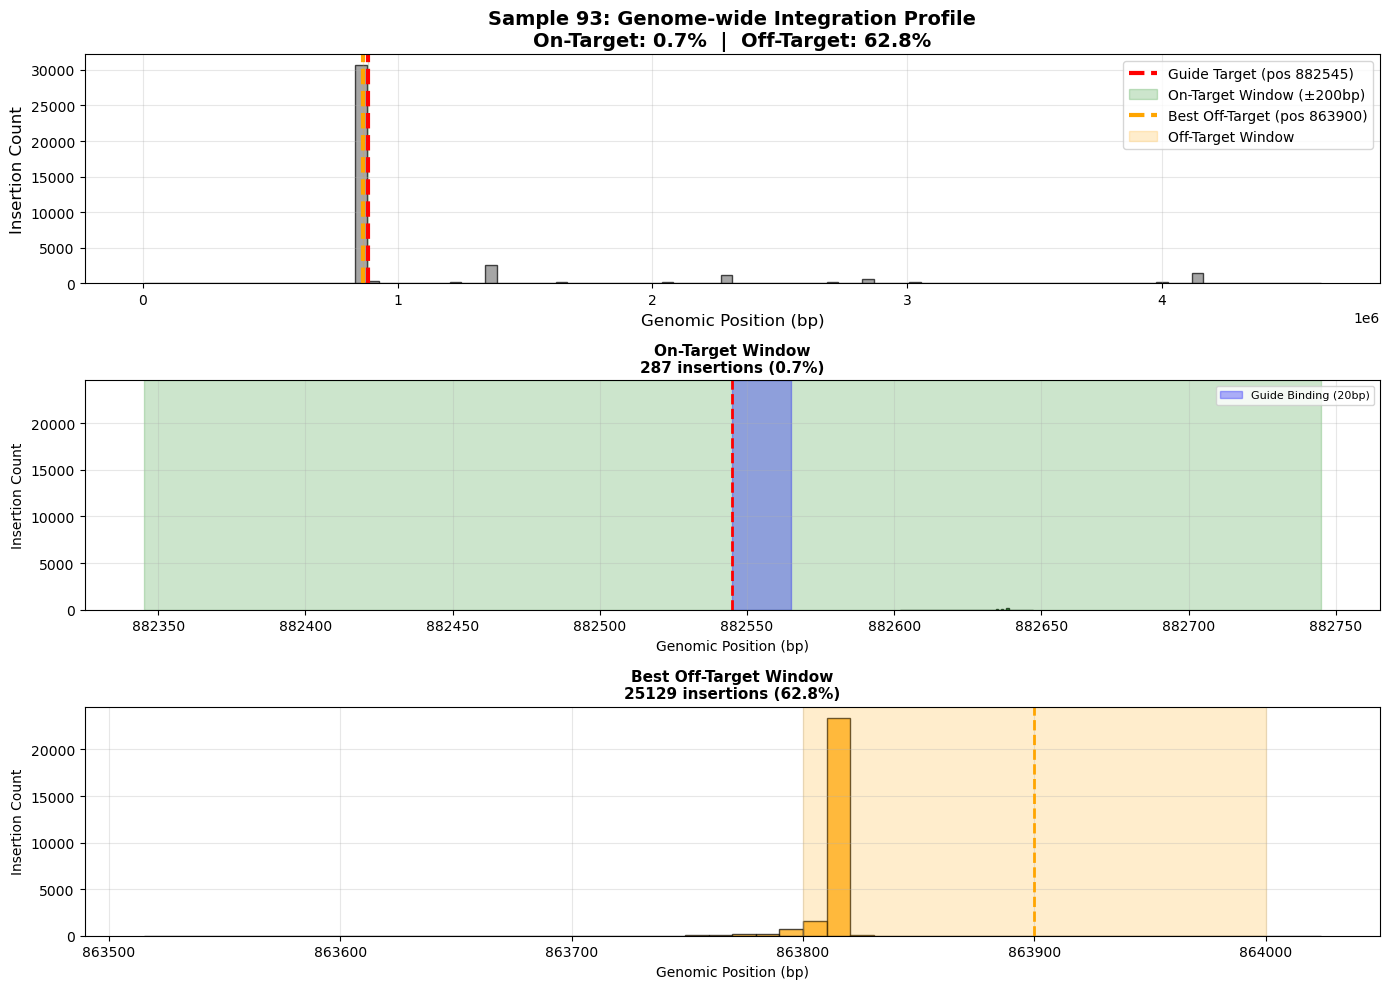


SAMPLE 93 ANALYSIS
Sample Name: 93_S93_L001_R1_001.insertions.5p
Total Insertions: 39,997

Guide Target Position: 882,545 bp
Guide Binding Region: 882,545 - 882,565 bp

On-Target Window: 882,345 - 882,745 bp (±200bp)
  Insertions: 287 (0.7%)

Best Off-Target Window: 863,800 - 864,000 bp
  Center Position: 863,900 bp
  Distance from Target: 18,645 bp
  Insertions: 25,129 (62.8%)

Off-Target Preference: +62.1%


In [15]:
# v2 zoomed in analysis of on vs off target windows
# Visualize on-target and off-target windows for a specific sample
# Set the sample you want to analyze
nn = 92  # Change this to your sample of interest

import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load sample data
tsv = pd.read_csv(tsv_files[nn], sep="\t")
tsv = tsv[tsv["mapq"] >= min_mapq]
insertions = tsv["ins0"].values.tolist()

# Get target position
gmap = php.map_guide_to_genome(guideRNA["protospacer"][nn], genome_sequence)
target_position = gmap[0]["start"]
guide_length = 20

# Find off-target windows
all_windows = find_high_integration_windows(insertions, window_size=200, min_window_count=30)
off_target_windows = [(center, count) for center, count in all_windows 
                      if abs(center - target_position) > 200]

# Get best off-target window
if off_target_windows:
    best_off_target_pos, best_off_target_count = off_target_windows[0]
else:
    best_off_target_pos, best_off_target_count = None, 0

# Calculate stats
on_target_count = sum(abs(pos - target_position) <= 200 for pos in insertions)
on_target_percent = 100.0 * on_target_count / len(insertions) if insertions else 0
off_target_percent = 100.0 * best_off_target_count / len(insertions) if insertions and best_off_target_pos else 0

# Create visualization
if best_off_target_pos:
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10))
else:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 7))

# Plot 1: Full genome view (UNCHANGED)
ax1.hist(insertions, bins=100, alpha=0.7, color='gray', edgecolor='black')
ax1.axvline(target_position, color='red', linewidth=3, label=f'Guide Target (pos {target_position})', linestyle='--')
ax1.axvspan(target_position - 200, target_position + 200, alpha=0.2, color='green', 
            label=f'On-Target Window (±200bp)')

if best_off_target_pos:
    ax1.axvline(best_off_target_pos, color='orange', linewidth=3, 
                label=f'Best Off-Target (pos {best_off_target_pos})', linestyle='--')
    ax1.axvspan(best_off_target_pos - 100, best_off_target_pos + 100, alpha=0.2, color='orange',
                label=f'Off-Target Window')

ax1.set_xlabel("Genomic Position (bp)", fontsize=12)
ax1.set_ylabel("Insertion Count", fontsize=12)
ax1.set_title(f"Sample {nn+1}: Genome-wide Integration Profile\nOn-Target: {on_target_percent:.1f}%  |  Off-Target: {off_target_percent:.1f}%", 
              fontsize=14, fontweight='bold')
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: On-target zoom (on separate line)
on_target_insertions = [pos for pos in insertions if target_position - 400 <= pos <= target_position + 400]
ax2.hist(on_target_insertions, bins=50, alpha=0.7, color='green', edgecolor='black')
ax2.axvline(target_position, color='red', linewidth=2, linestyle='--')
ax2.axvspan(target_position - 200, target_position + 200, alpha=0.2, color='green')
ax2.axvspan(target_position, target_position + guide_length, alpha=0.3, color='blue',
            label='Guide Binding (20bp)')

ax2.set_xlabel("Genomic Position (bp)", fontsize=10)
ax2.set_ylabel("Insertion Count", fontsize=10)
ax2.set_title(f"On-Target Window\n{on_target_count} insertions ({on_target_percent:.1f}%)", 
              fontsize=11, fontweight='bold')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

# Plot 3: Off-target zoom (on separate line)
if best_off_target_pos:
    off_target_insertions = [pos for pos in insertions 
                            if best_off_target_pos - 400 <= pos <= best_off_target_pos + 400]
    ax3.hist(off_target_insertions, bins=50, alpha=0.7, color='orange', edgecolor='black')
    ax3.axvline(best_off_target_pos, color='orange', linewidth=2, linestyle='--')
    ax3.axvspan(best_off_target_pos - 100, best_off_target_pos + 100, alpha=0.2, color='orange')
    ax3.set_xlabel("Genomic Position (bp)", fontsize=10)
    ax3.set_ylabel("Insertion Count", fontsize=10)
    ax3.set_title(f"Best Off-Target Window\n{best_off_target_count} insertions ({off_target_percent:.1f}%)", 
                  fontsize=11, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # Match y-axis scales between on-target and off-target
    max_y = max(ax2.get_ylim()[1], ax3.get_ylim()[1])
    ax2.set_ylim(0, max_y)
    ax3.set_ylim(0, max_y)

plt.tight_layout()
plt.show()

# Print detailed stats
print("\n" + "=" * 80)
print(f"SAMPLE {nn+1} ANALYSIS")
print("=" * 80)
print(f"Sample Name: {Path(tsv_files[nn]).stem}")
print(f"Total Insertions: {len(insertions):,}")
print(f"\nGuide Target Position: {target_position:,} bp")
print(f"Guide Binding Region: {target_position:,} - {target_position + guide_length:,} bp")
print(f"\nOn-Target Window: {target_position - 200:,} - {target_position + 200:,} bp (±200bp)")
print(f"  Insertions: {on_target_count:,} ({on_target_percent:.1f}%)")
if best_off_target_pos:
    distance = abs(best_off_target_pos - target_position)
    print(f"\nBest Off-Target Window: {best_off_target_pos - 100:,} - {best_off_target_pos + 100:,} bp")
    print(f"  Center Position: {best_off_target_pos:,} bp")
    print(f"  Distance from Target: {distance:,} bp")
    print(f"  Insertions: {best_off_target_count:,} ({off_target_percent:.1f}%)")
    print(f"\nOff-Target Preference: {off_target_percent - on_target_percent:+.1f}%")
else:
    print("\nNo significant off-target windows found (≥30 integrations)")
print("=" * 80)


In [18]:
# Check if selected ideal guides bind in best off-target windows
# For samples with strong off-target preference, find guide binding positions in off-target regions
# Uses Selected_Ideal_Guides.csv

import pandas as pd
from pathlib import Path

# Load the selected ideal guides CSV
selected_guides_csv = output_csv_dir / "02132026_Selected_Ideal_Guides.csv"

if not selected_guides_csv.exists():
    print(f"ERROR: {selected_guides_csv} not found")
else:
    df_selected = pd.read_csv(selected_guides_csv)
    
    # Extract sample_id from hotspot column (format: "sample_id_mcvN")
    df_selected['sample_id'] = df_selected['hotspot'].str.split('_').str[0].astype(int)
    
    # Get samples with strong off-target preference (top 10)
    top_off_target_samples = df_off_target.head(10)
    
    off_target_binding_results = []
    
    print("=" * 140)
    print("CHECKING IF SELECTED IDEAL GUIDES BIND IN BEST OFF-TARGET WINDOWS")
    print("=" * 140)
    
    for idx, off_target_row in top_off_target_samples.iterrows():
        sample_id = off_target_row['sample_id']
        nn = sample_id - 1
        
        print(f"\nSample {sample_id}: {off_target_row['sample_name']}")
        print(f"  Off-target preference: {off_target_row['off_target_preference']:.1f}%")
        print(f"  Best off-target window position: {off_target_row['best_off_target_window']:,}")
        print(f"  Best off-target window integrations: {off_target_row['best_off_target_count']}")
        
        # Get selected guides for this sample from CSV
        sample_guides = df_selected[df_selected['sample_id'] == sample_id]
        
        if sample_guides.empty:
            print(f"  No selected guides found for this sample")
            continue
        
        # Get insertion data for this sample
        tsv = pd.read_csv(tsv_files[nn], sep="\t")
        tsv = tsv[tsv["mapq"] >= min_mapq]
        insertions = tsv["ins0"].values.tolist()

        # Get insertion data for this sample
        tsv = pd.read_csv(tsv_files[nn], sep="\t")
        tsv = tsv[tsv["mapq"] >= min_mapq]
        insertions = tsv["ins0"].values.tolist()

        # Get strand info for insertions near the MCV
        mcv_position = insertion_site  # MCV position from guide_row
        if "strand" in tsv.columns:
            # Find insertions at exact MCV position
            mcv_insertions = tsv[tsv["ins0"] == mcv_position]
    
            if not mcv_insertions.empty:
                strand_counts = mcv_insertions["strand"].value_counts().to_dict()
                plus_count = strand_counts.get('+', 0)
                minus_count = strand_counts.get('-', 0)
                total_at_mcv = len(mcv_insertions)
                
                print(f"    Insertion strand distribution at MCV position {mcv_position:,}:")
                print(f"      + strand: {plus_count}")
                print(f"      - strand: {minus_count}")
                print(f"      Total: {total_at_mcv}")
            else:
                print(f"    No insertions found at exact MCV position {mcv_position:,}")
        else:
            print("    Strand column not available in TSV")
            
        # Get target position
        gmap = php.map_guide_to_genome(guideRNA["protospacer"][nn], genome_sequence)
        target_position = gmap[0]["start"]
        
        # Get best off-target window position
        best_off_target_window = off_target_row['best_off_target_window']
        
        # Check each selected guide to see if it aligns to the off-target window region
        for _, guide_row in sample_guides.iterrows():
            guide_seq = guide_row['guide_seq']
            hotspot = guide_row['hotspot']
            insertion_site = guide_row['insertion_site']  # MCV position
            distance_to_mcv = guide_row['distance_to_mcv']  # Distance from guide to MCV
            
            # Find where this guide sequence occurs in the genome near the off-target window
            # Search in ±500bp around the best off-target window
            search_start = max(0, int(best_off_target_window) - 500)
            search_end = min(len(genome_sequence), int(best_off_target_window) + 500)
            search_seq = genome_sequence[search_start:search_end]
            
            # Look for exact matches of guide sequence
            binding_positions = []
            for i in range(len(search_seq) - len(guide_seq) + 1):
                if search_seq[i:i+len(guide_seq)] == guide_seq:
                    genomic_pos = search_start + i
                    distance_to_window = abs(genomic_pos - best_off_target_window)
                    binding_positions.append((genomic_pos, distance_to_window))
            
            # Also check reverse complement
            revcomp_seq = revcomp(guide_seq)
            for i in range(len(search_seq) - len(revcomp_seq) + 1):
                if search_seq[i:i+len(revcomp_seq)] == revcomp_seq:
                    genomic_pos = search_start + i
                    distance_to_window = abs(genomic_pos - best_off_target_window)
                    binding_positions.append((genomic_pos, distance_to_window))
            
            if binding_positions:
                # Get closest binding position to off-target window
                binding_positions.sort(key=lambda x: x[1])
                best_binding_pos, min_distance = binding_positions[0]
                
                # Count insertions near this binding position
                nearby_insertions = sum(1 for pos in insertions 
                                       if abs(pos - best_binding_pos) <= 100)
                
                print(f"\n  {hotspot}:")
                print(f"    Guide sequence: {guide_seq}")
                print(f"    MCV position: {insertion_site:,}")
                print(f"    Distance from guide to MCV: {distance_to_mcv} bp")
                print(f"    Binding position in off-target region: {best_binding_pos:,}")
                print(f"    Distance to best off-target window: {min_distance} bp")
                print(f"    Insertions within ±100bp of binding: {nearby_insertions}")
                
                off_target_binding_results.append({
                    'sample_id': sample_id,
                    'sample_name': off_target_row['sample_name'],
                    'off_target_preference': off_target_row['off_target_preference'],
                    'hotspot': hotspot,
                    'guide_seq': guide_seq,
                    'mcv_position': insertion_site,
                    'distance_guide_to_mcv': distance_to_mcv,
                    'binding_position': best_binding_pos,
                    'best_off_target_window': int(best_off_target_window),
                    'distance_binding_to_window': min_distance,
                    'nearby_insertions': nearby_insertions,
                    'original_guide': guide_row.get('original_guide', '')
                })
            else:
                print(f"\n  {hotspot}: Guide does NOT bind in off-target window region")
    
    if off_target_binding_results:
        # Create summary DataFrame
        df_off_target_binding = pd.DataFrame(off_target_binding_results)
        df_off_target_binding = df_off_target_binding.sort_values('off_target_preference', ascending=False)
        
        print("\n" + "=" * 140)
        print("SUMMARY: SELECTED GUIDES BINDING IN OFF-TARGET WINDOWS")
        print("=" * 140)
        print(df_off_target_binding[['sample_id', 'sample_name', 'off_target_preference', 
                                     'hotspot', 'guide_seq', 'distance_guide_to_mcv',
                                     'binding_position', 'best_off_target_window',
                                     'distance_binding_to_window', 'nearby_insertions']].to_string(index=False))
        
        # Save to CSV
        output_csv = output_csv_dir / "02132026_T10_SelectedGuides.csv"
        df_off_target_binding.to_csv(output_csv, index=False)
        print(f"\n✓ Saved results to: {output_csv}")
    else:
        print("\nNo selected guides found binding in off-target windows")
        

CHECKING IF SELECTED IDEAL GUIDES BIND IN BEST OFF-TARGET WINDOWS

Sample 70: 70_S70_L001_R1_001.insertions.5p
  Off-target preference: 82.1%
  Best off-target window position: 4,471,500
  Best off-target window integrations: 29430
    No insertions found at exact MCV position 2,528,741

  70_mcv1:
    Guide sequence: GAGAGATCGACATATAAATC
    MCV position: 4,471,450
    Distance from guide to MCV: 69 bp
    Binding position in off-target region: 4,471,359
    Distance to best off-target window: 141 bp
    Insertions within ±100bp of binding: 29343

  70_mcv2: Guide does NOT bind in off-target window region

  70_mcv3: Guide does NOT bind in off-target window region

Sample 31: 31_S31_L001_R1_001.insertions.5p
  Off-target preference: 76.2%
  Best off-target window position: 2,170,900
  Best off-target window integrations: 15611
    No insertions found at exact MCV position 868,051

  31_mcv1:
    Guide sequence: GATATTGGCGCGGGCCAGTG
    MCV position: 2,170,825
    Distance from guide t

In [19]:
# messing around with cell directly above
# Check if selected ideal guides bind in best off-target windows
# For samples with strong off-target preference, find guide binding positions in off-target regions
# Uses Selected_Ideal_Guides.csv

import pandas as pd
from pathlib import Path

# Load the selected ideal guides CSV
selected_guides_csv = output_csv_dir / "02132026_Selected_Ideal_Guides.csv"

if not selected_guides_csv.exists():
    print(f"ERROR: {selected_guides_csv} not found")
else:
    df_selected = pd.read_csv(selected_guides_csv)
    
    # Extract sample_id from hotspot column (format: "sample_id_mcvN")
    df_selected['sample_id'] = df_selected['hotspot'].str.split('_').str[0].astype(int)
    
    # Get samples with strong off-target preference (top 10)
    top_off_target_samples = df_off_target.head(10)
    
    off_target_binding_results = []
    
    print("=" * 140)
    print("CHECKING IF SELECTED IDEAL GUIDES BIND IN BEST OFF-TARGET WINDOWS")
    print("=" * 140)
    
    for idx, off_target_row in top_off_target_samples.iterrows():
        sample_id = off_target_row['sample_id']
        nn = sample_id - 1
        
        print(f"\nSample {sample_id}: {off_target_row['sample_name']}")
        print(f"  Off-target preference: {off_target_row['off_target_preference']:.1f}%")
        print(f"  Best off-target window position: {off_target_row['best_off_target_window']:,}")
        print(f"  Best off-target window integrations: {off_target_row['best_off_target_count']}")
        
        # Get selected guides for this sample from CSV
        sample_guides = df_selected[df_selected['sample_id'] == sample_id]
        
        if sample_guides.empty:
            print(f"  No selected guides found for this sample")
            continue
        
        # Get insertion data for this sample
        tsv = pd.read_csv(tsv_files[nn], sep="\t")
        tsv = tsv[tsv["mapq"] >= min_mapq]
        insertions = tsv["ins0"].values.tolist()

        # Get insertion data for this sample
        tsv = pd.read_csv(tsv_files[nn], sep="\t")
        tsv = tsv[tsv["mapq"] >= min_mapq]
        insertions = tsv["ins0"].values.tolist()

        # Get strand info for insertions near the MCV
        mcv_position = insertion_site  # MCV position from guide_row
        if "strand" in tsv.columns:
            # Find insertions at exact MCV position
            mcv_insertions = tsv[tsv["ins0"] == mcv_position]
    
            if not mcv_insertions.empty:
                strand_counts = mcv_insertions["strand"].value_counts().to_dict()
                plus_count = strand_counts.get('+', 0)
                minus_count = strand_counts.get('-', 0)
                total_at_mcv = len(mcv_insertions)
                
                print(f"    Insertion strand distribution at MCV position {mcv_position:,}:")
                print(f"      + strand: {plus_count}")
                print(f"      - strand: {minus_count}")
                print(f"      Total: {total_at_mcv}")
            else:
                print(f"    No insertions found at exact MCV position {mcv_position:,}")
        else:
            print("    Strand column not available in TSV")
            
        # Get target position
        gmap = php.map_guide_to_genome(guideRNA["protospacer"][nn], genome_sequence)
        target_position = gmap[0]["start"]
        
        # Get best off-target window position
        best_off_target_window = off_target_row['best_off_target_window']
        
        # Check each selected guide to see if it aligns to the off-target window region
        for _, guide_row in sample_guides.iterrows():
            guide_seq = guide_row['guide_seq']
            hotspot = guide_row['hotspot']
            insertion_site = guide_row['insertion_site']  # MCV position
            distance_to_mcv = guide_row['distance_to_mcv']  # Distance from guide to MCV
            
            # Find where this guide sequence occurs in the genome near the off-target window
            # Search in ±500bp around the best off-target window
            search_start = max(0, int(best_off_target_window) - 500)
            search_end = min(len(genome_sequence), int(best_off_target_window) + 500)
            search_seq = genome_sequence[search_start:search_end]
            
            # Look for exact matches of guide sequence
            binding_positions = []
            for i in range(len(search_seq) - len(guide_seq) + 1):
                if search_seq[i:i+len(guide_seq)] == guide_seq:
                    genomic_pos = search_start + i
                    distance_to_window = abs(genomic_pos - best_off_target_window)
                    binding_positions.append((genomic_pos, distance_to_window))
            
            # Also check reverse complement
            revcomp_seq = revcomp(guide_seq)
            for i in range(len(search_seq) - len(revcomp_seq) + 1):
                if search_seq[i:i+len(revcomp_seq)] == revcomp_seq:
                    genomic_pos = search_start + i
                    distance_to_window = abs(genomic_pos - best_off_target_window)
                    binding_positions.append((genomic_pos, distance_to_window))
            
            if binding_positions:
                # Get closest binding position to off-target window
                binding_positions.sort(key=lambda x: x[1])
                best_binding_pos, min_distance = binding_positions[0]
                
                # Count insertions near this binding position
                binding_window = 50
                nearby_insertions = sum(1 for pos in insertions 
                                       if abs(pos - best_binding_pos) <= binding_window)
                
                # Get strand distribution in this window
                if "strand" in tsv.columns:
                    nearby_insertions_df = tsv[
                        (tsv["ins0"] >= best_binding_pos - binding_window) & 
                        (tsv["ins0"] <= best_binding_pos + binding_window)
                    ]
                    strand_counts = nearby_insertions_df["strand"].value_counts().to_dict()
                    plus_count = strand_counts.get('+', 0)
                    minus_count = strand_counts.get('-', 0)
                else:
                    plus_count = minus_count = 0
                
                print(f"\n  {hotspot}:")
                print(f"    Guide sequence: {guide_seq}")
                print(f"    MCV position: {insertion_site:,}")
                print(f"    Distance from guide to MCV: {distance_to_mcv} bp")
                print(f"    Binding position in off-target region: {best_binding_pos:,}")
                print(f"    Distance to best off-target window: {min_distance} bp")
                print(f"    Insertions within ±{binding_window}bp of binding: {nearby_insertions}")
                if "strand" in tsv.columns:
                    print(f"      + strand: {plus_count}, - strand: {minus_count}")
                
                off_target_binding_results.append({
                    'sample_id': sample_id,
                    'sample_name': off_target_row['sample_name'],
                    'off_target_preference': off_target_row['off_target_preference'],
                    'hotspot': hotspot,
                    'guide_seq': guide_seq,
                    'mcv_position': insertion_site,
                    'distance_guide_to_mcv': distance_to_mcv,
                    'binding_position': best_binding_pos,
                    'best_off_target_window': int(best_off_target_window),
                    'distance_binding_to_window': min_distance,
                    'nearby_insertions': nearby_insertions,
                    'original_guide': guide_row.get('original_guide', '')
                })
            else:
                print(f"\n  {hotspot}: Guide does NOT bind in off-target window region")
    
    if off_target_binding_results:
        # Create summary DataFrame
        df_off_target_binding = pd.DataFrame(off_target_binding_results)
        df_off_target_binding = df_off_target_binding.sort_values('off_target_preference', ascending=False)
        
        print("\n" + "=" * 140)
        print("SUMMARY: SELECTED GUIDES BINDING IN OFF-TARGET WINDOWS")
        print("=" * 140)
        print(df_off_target_binding[['sample_id', 'sample_name', 'off_target_preference', 
                                     'hotspot', 'guide_seq', 'distance_guide_to_mcv',
                                     'binding_position', 'best_off_target_window',
                                     'distance_binding_to_window', 'nearby_insertions']].to_string(index=False))
        
        # Save to CSV
        output_csv = output_csv_dir / "blahblahblah_02132026_T10_SelectedGuides.csv"
        df_off_target_binding.to_csv(output_csv, index=False)
        print(f"\n✓ Saved results to: {output_csv}")
    else:
        print("\nNo selected guides found binding in off-target windows")
        

CHECKING IF SELECTED IDEAL GUIDES BIND IN BEST OFF-TARGET WINDOWS

Sample 70: 70_S70_L001_R1_001.insertions.5p
  Off-target preference: 82.1%
  Best off-target window position: 4,471,500
  Best off-target window integrations: 29430
    No insertions found at exact MCV position 2,528,741

  70_mcv1:
    Guide sequence: GAGAGATCGACATATAAATC
    MCV position: 4,471,450
    Distance from guide to MCV: 69 bp
    Binding position in off-target region: 4,471,359
    Distance to best off-target window: 141 bp
    Insertions within ±50bp of binding: 45
      + strand: 0, - strand: 45

  70_mcv2: Guide does NOT bind in off-target window region

  70_mcv3: Guide does NOT bind in off-target window region

Sample 31: 31_S31_L001_R1_001.insertions.5p
  Off-target preference: 76.2%
  Best off-target window position: 2,170,900
  Best off-target window integrations: 15611
    No insertions found at exact MCV position 868,051

  31_mcv1:
    Guide sequence: GATATTGGCGCGGGCCAGTG
    MCV position: 2,170,8

In [30]:
# v3 single csv, calculate integration freq from cluster
# filtered candidate spacers single csv with insertion strand distribution and frequency columns 
# bulk run + filtering by NGG and distance
# Bulk: write per-sample CSVs but only include NGG guides 66-76 bp from their mcv
# ENHANCED: add strand distribution and hotspot frequency columns
# FIXED: integration_frequency now sums across all cluster members, not just rep_pos

import re
import pandas as pd
from collections import Counter
from pathlib import Path

def revcomp(seq):
    comp = str.maketrans("ACGTacgt", "TGCAtgca")
    return seq.translate(comp)[::-1]

def _sample_id_from_name(p: Path):
    m = re.match(r"(\d+)_S\1_", p.name)
    return int(m.group(1)) if m else None

written = []
skipped = []
all_rows = []

for nn, tsv_path in enumerate(tsv_files):
    sample_id = _sample_id_from_name(tsv_path) or (nn + 1)

    # load + basic filter (min_mapq expected in notebook)
    tsv = pd.read_csv(tsv_path, sep="\t")
    tsv = tsv[tsv["mapq"] >= min_mapq]
    
    # Calculate total insertions in sample and strand counts per insertion position
    total_insertions = len(tsv)
    insertion_strands = {}  # {position: {'+': count, '-': count}}
    for _, row in tsv.iterrows():
        pos = row["ins0"]
        strand = row.get("strand", "+")  # default to + if not present
        if pos not in insertion_strands:
            insertion_strands[pos] = {'+': 0, '-': 0}
        insertion_strands[pos][strand] = insertion_strands[pos].get(strand, 0) + 1

    # collapse hotspots (same logic as before)
    collapse_bp = 5
    min_reads = 500

    counts = Counter(tsv["ins0"])
    gmap = php.map_guide_to_genome(guideRNA["protospacer"][nn], genome_sequence)
    target_position = gmap[0]["start"]
    counts[target_position] = counts.get(target_position, 0)

    clusters = [{"members": {pos: freq}, "total": freq} for pos, freq in counts.items()]
    merged = True
    while merged:
        merged = False
        new_clusters = []
        while clusters:
            c = clusters.pop(0)
            i = 0
            while i < len(clusters):
                other = clusters[i]
                close = any(abs(p - q) <= collapse_bp for p in c["members"] for q in other["members"])
                if close:
                    for p, f in other["members"].items():
                        c["members"][p] = c["members"].get(p, 0) + f
                    c["total"] += other["total"]
                    clusters.pop(i)
                    merged = True
                else:
                    i += 1
            new_clusters.append(c)
        clusters = new_clusters

    clusters_info = []
    for c in clusters:
        rep_pos, rep_count = max(c["members"].items(), key=lambda x: x[1])
        clusters_info.append({
            "rep_pos": int(rep_pos),
            "rep_count": int(rep_count),
            "total": int(c["total"]),
            "members": sorted(c["members"].keys()),
            "contains_target": (target_position in c["members"])
        })

    filtered = [c for c in clusters_info if c["total"] > min_reads]
    if not any(c["contains_target"] for c in filtered):
        for c in clusters_info:
            if c["contains_target"]:
                filtered.append(c)
                break

    filtered.sort(key=lambda x: x["total"], reverse=True)
    for idx, c in enumerate(filtered, start=1):
        c["mcv_id"] = idx

    # Build a lookup: rep_pos -> cluster info (for fast integration frequency calculation)
    cluster_lookup = {c["rep_pos"]: c for c in filtered}

    mcv_list = [c["rep_pos"] for c in filtered]
    hotspots = {f"mcv{idx}": pos for idx, pos in enumerate(mcv_list, start=1)}
    for idx, pos in enumerate(mcv_list, start=1):
        globals()[f"mcv{idx}"] = pos

    # Generate guides (methods 1,2,3) exactly as before
    original_guide = guideRNA["protospacer"][nn]
    hotspots_dict = hotspots if (isinstance(hotspots, dict) and hotspots) else ({f"mcv{i+1}": pos for i,pos in enumerate(mcv_list)} if "mcv_list" in globals() else {})
    _alignment_ctx = {}
    for hotspot_name, insertion_site in hotspots_dict.items():
        window_start = max(0, insertion_site - 120)
        window_end = min(len(genome_sequence), insertion_site + 120)
        window_seq = genome_sequence[window_start:window_end]

        aln_fwd = php.local_align(original_guide, window_seq)
        aln_rev = php.local_align(original_guide, revcomp(window_seq))

        if aln_fwd.score >= aln_rev.score:
            best_aln = aln_fwd
            best_strand = "+"
            search_seq = window_seq
        else:
            best_aln = aln_rev
            best_strand = "-"
            search_seq = revcomp(window_seq)

        _alignment_ctx[hotspot_name] = {
            "insertion_site": insertion_site,
            "window_start": window_start,
            "window_end": window_end,
            "window_seq": window_seq,
            "best_aln": best_aln,
            "best_strand": best_strand,
            "search_seq": search_seq,
        }

    rows = []

    window_radius = 120
    # Method 1
    for hotspot_name, insertion_site in hotspots_dict.items():
        win_start = max(0, insertion_site - window_radius)
        win_end = min(len(genome_sequence), insertion_site + window_radius)
        win_seq = genome_sequence[win_start:win_end]

        for i in range(len(win_seq) - 2):
            pam = win_seq[i:i+3]
            if pam[1:3] == "GG":
                pam_genomic_start = win_start + i
                pam_genomic_end = pam_genomic_start + 3
                guide_start = pam_genomic_start - 20
                guide_end = pam_genomic_start
                if guide_start < 0:
                    continue
                guide_seq = genome_sequence[guide_start:guide_end]
                dist = abs((pam_genomic_end - 1) - insertion_site)
                try:
                    aln_score = php.local_align(original_guide, guide_seq).score
                except Exception:
                    aln_score = None
                mismatch_count = sum(a != b for a, b in zip(original_guide, guide_seq))
                rows.append({
                    "hotspot": hotspot_name,
                    "method": 1,
                    "pam_type": "NGG",
                    "pam_seq": pam,
                    "guide_seq": guide_seq,
                    "guide_start": int(guide_start),
                    "guide_end": int(guide_end),
                    "strand": "+",
                    "mismatch_count": int(mismatch_count),
                    "alignment_score": aln_score,
                    "distance_to_mcv": int(dist),
                    "insertion_site": int(insertion_site)
                })

        for i in range(len(win_seq) - 2):
            motif = win_seq[i:i+3]
            if motif[0:2] == "CC":
                pam_genomic_start = win_start + i
                pam_genomic_end = pam_genomic_start + 3
                guide_start = pam_genomic_end
                guide_end = guide_start + 20
                if guide_end > len(genome_sequence):
                    continue
                guide_seq = revcomp(genome_sequence[guide_start:guide_end])
                dist = abs(pam_genomic_start - insertion_site)
                try:
                    aln_score = php.local_align(original_guide, guide_seq).score
                except Exception:
                    aln_score = None
                mismatch_count = sum(a != b for a, b in zip(original_guide, guide_seq))
                rows.append({
                    "hotspot": hotspot_name,
                    "method": 1,
                    "pam_type": "NGG",
                    "pam_seq": revcomp(motif),
                    "guide_seq": guide_seq,
                    "guide_start": int(guide_start),
                    "guide_end": int(guide_end),
                    "strand": "-",
                    "mismatch_count": int(mismatch_count),
                    "alignment_score": aln_score,
                    "distance_to_mcv": int(dist),
                    "insertion_site": int(insertion_site)
                })

    # Method 2
    for hotspot_name, ctx in _alignment_ctx.items():
        insertion_site = ctx["insertion_site"]
        window_start = ctx["window_start"]
        window_seq = ctx["window_seq"]
        best_aln = ctx["best_aln"]
        best_strand = ctx["best_strand"]
        search_seq = ctx["search_seq"]

        target_coords = best_aln.coordinates[1]
        target_start = int(target_coords[0])
        target_end = int(target_coords[-1])

        if best_strand == "+":
            genomic_start = window_start + target_start
            genomic_end = window_start + target_end
        else:
            genomic_start = window_start + (len(window_seq) - target_end)
            genomic_end = window_start + (len(window_seq) - target_start)

        coords_q = best_aln.coordinates[0]
        coords_t = best_aln.coordinates[1]

        query_seq = best_aln.query
        target_seq = best_aln.target

        first_match_query_pos = None
        first_match_target_pos = None
        query_pos = 0
        target_pos = 0
        for q, t in zip(query_seq, target_seq):
            if q != "-" and t != "-" and q == t:
                first_match_query_pos = query_pos
                first_match_target_pos = target_pos
                break
            if q != "-":
                query_pos += 1
            if t != "-":
                target_pos += 1

        if first_match_query_pos is not None:
            first_match_genomic = genomic_start + first_match_target_pos
            new_guide_start = first_match_genomic - first_match_query_pos
            new_guide_end = new_guide_start + 20
            if 0 <= new_guide_start and new_guide_end <= len(genome_sequence):
                if best_strand == "+":
                    new_guide = genome_sequence[new_guide_start:new_guide_end]
                    new_guide_gstart = new_guide_start
                    new_guide_gend = new_guide_end
                else:
                    new_guide = revcomp(genome_sequence[new_guide_start:new_guide_end])
                    new_guide_gstart = new_guide_start
                    new_guide_gend = new_guide_end

                if best_strand == "+":
                    five_prime_start = target_start - 3
                    five_prime_end = target_start
                    five_prime_seq = window_seq[five_prime_start:five_prime_end] if five_prime_start >= 0 else ""
                    distance_to_mcv = abs(new_guide_gstart - insertion_site)
                else:
                    five_prime_start = target_end
                    five_prime_end = target_end + 3
                    five_prime_seq = revcomp(window_seq)[five_prime_start:five_prime_end] if five_prime_end <= len(window_seq) else ""
                    distance_to_mcv = abs(new_guide_gend - insertion_site)

                pam_type = None
                pam_seq = five_prime_seq
                if len(pam_seq) == 3:
                    if pam_seq[1:3] == "GG":
                        pam_type = "NGG"
                    elif pam_seq[1:3] == "AG":
                        pam_type = "NAG"
                    elif pam_seq[1:3] == "GA":
                        pam_type = "NGA"

                if pam_type:
                    mismatch_count = sum(a != b for a, b in zip(original_guide, new_guide))
                    try:
                        aln_score = php.local_align(original_guide, new_guide).score
                    except Exception:
                        aln_score = None

                    rows.append({
                        "hotspot": hotspot_name,
                        "method": 2,
                        "pam_type": pam_type,
                        "pam_seq": pam_seq,
                        "guide_seq": new_guide,
                        "guide_start": int(new_guide_gstart),
                        "guide_end": int(new_guide_gend),
                        "strand": best_strand,
                        "mismatch_count": int(mismatch_count),
                        "alignment_score": aln_score,
                        "distance_to_mcv": int(distance_to_mcv),
                        "insertion_site": int(insertion_site)
                    })

    # Method 3
    for hotspot_name, ctx in _alignment_ctx.items():
        insertion_site = ctx["insertion_site"]
        window_start = ctx["window_start"]
        window_seq = ctx["window_seq"]
        best_aln = ctx["best_aln"]
        best_strand = ctx["best_strand"]

        target_coords = best_aln.coordinates[1]
        target_start = int(target_coords[0])
        target_end = int(target_coords[-1])

        if best_strand == "+":
            genomic_start = window_start + target_start
            genomic_end = window_start + target_end
        else:
            genomic_start = window_start + (len(window_seq) - target_end)
            genomic_end = window_start + (len(window_seq) - target_start)

        alignment_center = (genomic_start + genomic_end) // 2
        pam_search_start = max(0, alignment_center - 25)
        pam_search_end = min(len(genome_sequence), alignment_center + 25)
        pam_search_seq = genome_sequence[pam_search_start:pam_search_end]

        for i in range(len(pam_search_seq) - 2):
            pam_motif = pam_search_seq[i:i+3]
            pam_type = None
            if pam_motif[1:3] == "GG":
                pam_type = "NGG"
            elif pam_motif[1:3] == "AG":
                pam_type = "NAG"
            elif pam_motif[1:3] == "GA":
                pam_type = "NGA"
            if not pam_type:
                continue

            pam_genomic_start = pam_search_start + i
            pam_genomic_end = pam_genomic_start + 3

            guide_start = pam_genomic_start - 20
            guide_end = pam_genomic_start
            if guide_start >= 0:
                guide_seq = genome_sequence[guide_start:guide_end]
                mismatch_count = sum(a != b for a, b in zip(original_guide, guide_seq))
                try:
                    aln_score = php.local_align(original_guide, guide_seq).score
                except Exception:
                    aln_score = None
                distance_to_mcv = abs(pam_genomic_end - insertion_site)
                rows.append({
                    "hotspot": hotspot_name,
                    "method": 3,
                    "pam_type": pam_type,
                    "pam_seq": genome_sequence[pam_genomic_start:pam_genomic_end],
                    "guide_seq": guide_seq,
                    "guide_start": int(guide_start),
                    "guide_end": int(guide_end),
                    "strand": "+",
                    "mismatch_count": int(mismatch_count),
                    "alignment_score": aln_score,
                    "distance_to_mcv": int(distance_to_mcv),
                    "insertion_site": int(insertion_site)
                })

        for i in range(len(pam_search_seq) - 2):
            pam_motif = pam_search_seq[i:i+3]
            pam_type = None
            if pam_motif[0:2] == "CC":
                pam_type = "NGG"
            elif pam_motif[0:2] == "CT":
                pam_type = "NAG"
            elif pam_motif[0:2] == "TC":
                pam_type = "NGA"
            if not pam_type:
                continue

            pam_genomic_start = pam_search_start + i
            pam_genomic_end = pam_genomic_start + 3

            guide_start = pam_genomic_end
            guide_end = guide_start + 20
            if guide_end <= len(genome_sequence):
                guide_seq = revcomp(genome_sequence[guide_start:guide_end])
                mismatch_count = sum(a != b for a, b in zip(original_guide, guide_seq))
                try:
                    aln_score = php.local_align(original_guide, guide_seq).score
                except Exception:
                    aln_score = None
                distance_to_mcv = abs(pam_genomic_start - insertion_site)
                rows.append({
                    "hotspot": hotspot_name,
                    "method": 3,
                    "pam_type": pam_type,
                    "pam_seq": revcomp(genome_sequence[pam_genomic_start:pam_genomic_end]),
                    "guide_seq": guide_seq,
                    "guide_start": int(guide_start),
                    "guide_end": int(guide_end),
                    "strand": "-",
                    "mismatch_count": int(mismatch_count),
                    "alignment_score": aln_score,
                    "distance_to_mcv": int(distance_to_mcv),
                    "insertion_site": int(insertion_site)
                })

    # assemble DataFrame and compute PAM coords
    def compute_pam_coords(row):
        try:
            gs = int(row['guide_start']); ge = int(row['guide_end']); strand = row['strand']
        except Exception:
            return pd.Series([None, None])
        if strand == "+":
            return pd.Series([ge, ge + 3])
        else:
            return pd.Series([gs - 3, gs])

    df = pd.DataFrame(rows)
    if df.empty:
        skipped.append((sample_id, str(tsv_path), "No candidates generated"))
        continue

    df[['pam_start', 'pam_end']] = df.apply(compute_pam_coords, axis=1)
    df = df.dropna(subset=['pam_start','pam_end']).reset_index(drop=True)
    df['pam_start'] = df['pam_start'].astype(int)
    df['pam_end'] = df['pam_end'].astype(int)

    pams_unique = df[['hotspot','pam_start','pam_end','pam_type']].drop_duplicates().reset_index(drop=True)
    def overlap(a_s, a_e, b_s, b_e):
        return (a_s < b_e) and (b_s < a_e)

    pams_unique['overlap_any'] = False
    pams_unique['overlap_noncanonical'] = False
    pams_unique['adj_left_any'] = False
    pams_unique['adj_left_noncanonical'] = False
    pams_unique['adj_right_any'] = False
    pams_unique['adj_right_noncanonical'] = False

    for idx, p in pams_unique.iterrows():
        ps, pe, ptype, hotspot = int(p.pam_start), int(p.pam_end), p.pam_type, p.hotspot
        partners = pams_unique[(pams_unique.hotspot == hotspot) & ~((pams_unique.pam_start == ps) & (pams_unique.pam_end == pe))]
        for _, q in partners.iterrows():
            qs, qe, qtype = int(q.pam_start), int(q.pam_end), q.pam_type
            if overlap(ps,pe,qs,qe):
                pams_unique.at[idx,'overlap_any'] = True
                if qtype != "NGG":
                    pams_unique.at[idx,'overlap_noncanonical'] = True
            if qe == ps:
                pams_unique.at[idx,'adj_left_any'] = True
                if qtype != "NGG":
                    pams_unique.at[idx,'adj_left_noncanonical'] = True
            if qs == pe:
                pams_unique.at[idx,'adj_right_any'] = True
                if qtype != "NGG":
                    pams_unique.at[idx,'adj_right_noncanonical'] = True

    df = df.merge(pams_unique, on=['hotspot','pam_start','pam_end','pam_type'], how='left', suffixes=('','_u'))
    
    # Keep only NGG rows and then further filter 66-76 bp
    df_ngg = df[df['pam_type'] == 'NGG'].copy()
    df_ngg_filtered = df_ngg[df_ngg['distance_to_mcv'].between(66, 76)].copy()

    if df_ngg_filtered.empty:
        skipped.append((sample_id, str(tsv_path), "No NGG candidates 66-76 bp"))
        continue

    # Add two new columns: strand_distribution and integration_frequency
    # strand_distribution: "#+ vs #-" format showing insertion counts at that hotspot by strand
    # integration_frequency: sum of all insertions in the cluster / total sample insertions
    def calc_integration_freq(pos):
        cluster = cluster_lookup.get(pos)
        if cluster:
            cluster_total = cluster['total']
            if cluster_total > 0 and total_insertions > 0:
                freq = 100.0 * cluster_total / total_insertions
                return f"{freq:.2f}%"
            elif cluster.get('contains_target', False):
                # This is the target site with no actual integration reads
                return "Target (0%)"
        return "0.00%"
    
    def calc_strand_dist(pos):
        cluster = cluster_lookup.get(pos)
        if cluster:
            plus_total = 0
            minus_total = 0
            for member_pos in cluster['members']:
                strands = insertion_strands.get(member_pos, {'+': 0, '-': 0})
                plus_total += strands.get('+', 0)
                minus_total += strands.get('-', 0)
            if plus_total == 0 and minus_total == 0 and cluster.get('contains_target', False):
                return "Target (0/0)"
            return f"{plus_total}/{minus_total}"
        return "0/0"
    
    df_ngg_filtered['strand_distribution'] = df_ngg_filtered['insertion_site'].apply(calc_strand_dist)
    df_ngg_filtered['integration_frequency'] = df_ngg_filtered['insertion_site'].apply(calc_integration_freq)
    
    # Rename 'strand' column to 'pam_strand' for clarity
    df_ngg_filtered = df_ngg_filtered.rename(columns={'strand': 'pam_strand'})
    
    # relabel hotspot with sample prefix: [sample]_mcv[n]
    df_ngg_filtered['hotspot'] = df_ngg_filtered['hotspot'].apply(lambda h: f"{sample_id}_{h}")

    # collect rows for global aggregation
    all_rows.append(df_ngg_filtered)

# combine all samples and write one CSV
if not all_rows:
    print("No candidates across samples after filtering.")
else:
    combined = pd.concat(all_rows, ignore_index=True)
    out_name = output_csv_dir / "CandidateSpacers_AllSamples_filtered_combined.csv"
    combined.to_csv(out_name, index=False)
    print(f"Wrote combined CSV: {out_name}  (rows: {len(combined)})")

if skipped:
    print(f"Skipped {len(skipped)} samples (no candidates after filtering).")

Wrote combined CSV: /Users/ecreed/Desktop/KelloggRotation/02052026_TagmentatioAnalysis_251218_260117_260203_combined/FilteredCandidateSpacersBulk/CandidateSpacers_AllSamples_filtered_combined.csv  (rows: 5230)


In [25]:
# v2 filtered candidate spacers single csv with insertion strand distribution and frequency collumns 
# bulk run + filtering by NGG and distance
# Bulk: write per-sample CSVs but only include NGG guides 66-76 bp from their mcv
# ENHANCED: add strand distribution and hotspot frequency columns

import re
import pandas as pd
from collections import Counter
from pathlib import Path

def revcomp(seq):
    comp = str.maketrans("ACGTacgt", "TGCAtgca")
    return seq.translate(comp)[::-1]

def _sample_id_from_name(p: Path):
    m = re.match(r"(\d+)_S\1_", p.name)
    return int(m.group(1)) if m else None

written = []
skipped = []
all_rows = []

for nn, tsv_path in enumerate(tsv_files):
    sample_id = _sample_id_from_name(tsv_path) or (nn + 1)

    # load + basic filter (min_mapq expected in notebook)
    tsv = pd.read_csv(tsv_path, sep="\t")
    tsv = tsv[tsv["mapq"] >= min_mapq]
    
    # Calculate total insertions in sample and strand counts per insertion position
    total_insertions = len(tsv)
    insertion_strands = {}  # {position: {'+': count, '-': count}}
    for _, row in tsv.iterrows():
        pos = row["ins0"]
        strand = row.get("strand", "+")  # default to + if not present
        if pos not in insertion_strands:
            insertion_strands[pos] = {'+': 0, '-': 0}
        insertion_strands[pos][strand] = insertion_strands[pos].get(strand, 0) + 1

    # collapse hotspots (same logic as before)
    collapse_bp = 5
    min_reads = 500

    counts = Counter(tsv["ins0"])
    gmap = php.map_guide_to_genome(guideRNA["protospacer"][nn], genome_sequence)
    target_position = gmap[0]["start"]
    counts[target_position] = counts.get(target_position, 0)

    clusters = [{"members": {pos: freq}, "total": freq} for pos, freq in counts.items()]
    merged = True
    while merged:
        merged = False
        new_clusters = []
        while clusters:
            c = clusters.pop(0)
            i = 0
            while i < len(clusters):
                other = clusters[i]
                close = any(abs(p - q) <= collapse_bp for p in c["members"] for q in other["members"])
                if close:
                    for p, f in other["members"].items():
                        c["members"][p] = c["members"].get(p, 0) + f
                    c["total"] += other["total"]
                    clusters.pop(i)
                    merged = True
                else:
                    i += 1
            new_clusters.append(c)
        clusters = new_clusters

    clusters_info = []
    for c in clusters:
        rep_pos, rep_count = max(c["members"].items(), key=lambda x: x[1])
        clusters_info.append({
            "rep_pos": int(rep_pos),
            "rep_count": int(rep_count),
            "total": int(c["total"]),
            "members": sorted(c["members"].keys()),
            "contains_target": (target_position in c["members"])
        })

    filtered = [c for c in clusters_info if c["total"] > min_reads]
    if not any(c["contains_target"] for c in filtered):
        for c in clusters_info:
            if c["contains_target"]:
                filtered.append(c)
                break

    filtered.sort(key=lambda x: x["total"], reverse=True)
    for idx, c in enumerate(filtered, start=1):
        c["mcv_id"] = idx

    mcv_list = [c["rep_pos"] for c in filtered]
    hotspots = {f"mcv{idx}": pos for idx, pos in enumerate(mcv_list, start=1)}
    for idx, pos in enumerate(mcv_list, start=1):
        globals()[f"mcv{idx}"] = pos

    # Generate guides (methods 1,2,3) exactly as before
    original_guide = guideRNA["protospacer"][nn]
    hotspots_dict = hotspots if (isinstance(hotspots, dict) and hotspots) else ({f"mcv{i+1}": pos for i,pos in enumerate(mcv_list)} if "mcv_list" in globals() else {})
    _alignment_ctx = {}
    for hotspot_name, insertion_site in hotspots_dict.items():
        window_start = max(0, insertion_site - 120)
        window_end = min(len(genome_sequence), insertion_site + 120)
        window_seq = genome_sequence[window_start:window_end]

        aln_fwd = php.local_align(original_guide, window_seq)
        aln_rev = php.local_align(original_guide, revcomp(window_seq))

        if aln_fwd.score >= aln_rev.score:
            best_aln = aln_fwd
            best_strand = "+"
            search_seq = window_seq
        else:
            best_aln = aln_rev
            best_strand = "-"
            search_seq = revcomp(window_seq)

        _alignment_ctx[hotspot_name] = {
            "insertion_site": insertion_site,
            "window_start": window_start,
            "window_end": window_end,
            "window_seq": window_seq,
            "best_aln": best_aln,
            "best_strand": best_strand,
            "search_seq": search_seq,
        }

    rows = []

    window_radius = 120
    # Method 1
    for hotspot_name, insertion_site in hotspots_dict.items():
        win_start = max(0, insertion_site - window_radius)
        win_end = min(len(genome_sequence), insertion_site + window_radius)
        win_seq = genome_sequence[win_start:win_end]

        for i in range(len(win_seq) - 2):
            pam = win_seq[i:i+3]
            if pam[1:3] == "GG":
                pam_genomic_start = win_start + i
                pam_genomic_end = pam_genomic_start + 3
                guide_start = pam_genomic_start - 20
                guide_end = pam_genomic_start
                if guide_start < 0:
                    continue
                guide_seq = genome_sequence[guide_start:guide_end]
                dist = abs((pam_genomic_end - 1) - insertion_site)
                try:
                    aln_score = php.local_align(original_guide, guide_seq).score
                except Exception:
                    aln_score = None
                mismatch_count = sum(a != b for a, b in zip(original_guide, guide_seq))
                rows.append({
                    "hotspot": hotspot_name,
                    "method": 1,
                    "pam_type": "NGG",
                    "pam_seq": pam,
                    "guide_seq": guide_seq,
                    "guide_start": int(guide_start),
                    "guide_end": int(guide_end),
                    "strand": "+",
                    "mismatch_count": int(mismatch_count),
                    "alignment_score": aln_score,
                    "distance_to_mcv": int(dist),
                    "insertion_site": int(insertion_site)
                })

        for i in range(len(win_seq) - 2):
            motif = win_seq[i:i+3]
            if motif[0:2] == "CC":
                pam_genomic_start = win_start + i
                pam_genomic_end = pam_genomic_start + 3
                guide_start = pam_genomic_end
                guide_end = guide_start + 20
                if guide_end > len(genome_sequence):
                    continue
                guide_seq = revcomp(genome_sequence[guide_start:guide_end])
                dist = abs(pam_genomic_start - insertion_site)
                try:
                    aln_score = php.local_align(original_guide, guide_seq).score
                except Exception:
                    aln_score = None
                mismatch_count = sum(a != b for a, b in zip(original_guide, guide_seq))
                rows.append({
                    "hotspot": hotspot_name,
                    "method": 1,
                    "pam_type": "NGG",
                    "pam_seq": revcomp(motif),
                    "guide_seq": guide_seq,
                    "guide_start": int(guide_start),
                    "guide_end": int(guide_end),
                    "strand": "-",
                    "mismatch_count": int(mismatch_count),
                    "alignment_score": aln_score,
                    "distance_to_mcv": int(dist),
                    "insertion_site": int(insertion_site)
                })

    # Method 2
    for hotspot_name, ctx in _alignment_ctx.items():
        insertion_site = ctx["insertion_site"]
        window_start = ctx["window_start"]
        window_seq = ctx["window_seq"]
        best_aln = ctx["best_aln"]
        best_strand = ctx["best_strand"]
        search_seq = ctx["search_seq"]

        target_coords = best_aln.coordinates[1]
        target_start = int(target_coords[0])
        target_end = int(target_coords[-1])

        if best_strand == "+":
            genomic_start = window_start + target_start
            genomic_end = window_start + target_end
        else:
            genomic_start = window_start + (len(window_seq) - target_end)
            genomic_end = window_start + (len(window_seq) - target_start)

        coords_q = best_aln.coordinates[0]
        coords_t = best_aln.coordinates[1]

        query_seq = best_aln.query
        target_seq = best_aln.target

        first_match_query_pos = None
        first_match_target_pos = None
        query_pos = 0
        target_pos = 0
        for q, t in zip(query_seq, target_seq):
            if q != "-" and t != "-" and q == t:
                first_match_query_pos = query_pos
                first_match_target_pos = target_pos
                break
            if q != "-":
                query_pos += 1
            if t != "-":
                target_pos += 1

        if first_match_query_pos is not None:
            first_match_genomic = genomic_start + first_match_target_pos
            new_guide_start = first_match_genomic - first_match_query_pos
            new_guide_end = new_guide_start + 20
            if 0 <= new_guide_start and new_guide_end <= len(genome_sequence):
                if best_strand == "+":
                    new_guide = genome_sequence[new_guide_start:new_guide_end]
                    new_guide_gstart = new_guide_start
                    new_guide_gend = new_guide_end
                else:
                    new_guide = revcomp(genome_sequence[new_guide_start:new_guide_end])
                    new_guide_gstart = new_guide_start
                    new_guide_gend = new_guide_end

                if best_strand == "+":
                    five_prime_start = target_start - 3
                    five_prime_end = target_start
                    five_prime_seq = window_seq[five_prime_start:five_prime_end] if five_prime_start >= 0 else ""
                    distance_to_mcv = abs(new_guide_gstart - insertion_site)
                else:
                    five_prime_start = target_end
                    five_prime_end = target_end + 3
                    five_prime_seq = revcomp(window_seq)[five_prime_start:five_prime_end] if five_prime_end <= len(window_seq) else ""
                    distance_to_mcv = abs(new_guide_gend - insertion_site)

                pam_type = None
                pam_seq = five_prime_seq
                if len(pam_seq) == 3:
                    if pam_seq[1:3] == "GG":
                        pam_type = "NGG"
                    elif pam_seq[1:3] == "AG":
                        pam_type = "NAG"
                    elif pam_seq[1:3] == "GA":
                        pam_type = "NGA"

                if pam_type:
                    mismatch_count = sum(a != b for a, b in zip(original_guide, new_guide))
                    try:
                        aln_score = php.local_align(original_guide, new_guide).score
                    except Exception:
                        aln_score = None

                    rows.append({
                        "hotspot": hotspot_name,
                        "method": 2,
                        "pam_type": pam_type,
                        "pam_seq": pam_seq,
                        "guide_seq": new_guide,
                        "guide_start": int(new_guide_gstart),
                        "guide_end": int(new_guide_gend),
                        "strand": best_strand,
                        "mismatch_count": int(mismatch_count),
                        "alignment_score": aln_score,
                        "distance_to_mcv": int(distance_to_mcv),
                        "insertion_site": int(insertion_site)
                    })

    # Method 3
    for hotspot_name, ctx in _alignment_ctx.items():
        insertion_site = ctx["insertion_site"]
        window_start = ctx["window_start"]
        window_seq = ctx["window_seq"]
        best_aln = ctx["best_aln"]
        best_strand = ctx["best_strand"]

        target_coords = best_aln.coordinates[1]
        target_start = int(target_coords[0])
        target_end = int(target_coords[-1])

        if best_strand == "+":
            genomic_start = window_start + target_start
            genomic_end = window_start + target_end
        else:
            genomic_start = window_start + (len(window_seq) - target_end)
            genomic_end = window_start + (len(window_seq) - target_start)

        alignment_center = (genomic_start + genomic_end) // 2
        pam_search_start = max(0, alignment_center - 25)
        pam_search_end = min(len(genome_sequence), alignment_center + 25)
        pam_search_seq = genome_sequence[pam_search_start:pam_search_end]

        for i in range(len(pam_search_seq) - 2):
            pam_motif = pam_search_seq[i:i+3]
            pam_type = None
            if pam_motif[1:3] == "GG":
                pam_type = "NGG"
            elif pam_motif[1:3] == "AG":
                pam_type = "NAG"
            elif pam_motif[1:3] == "GA":
                pam_type = "NGA"
            if not pam_type:
                continue

            pam_genomic_start = pam_search_start + i
            pam_genomic_end = pam_genomic_start + 3

            guide_start = pam_genomic_start - 20
            guide_end = pam_genomic_start
            if guide_start >= 0:
                guide_seq = genome_sequence[guide_start:guide_end]
                mismatch_count = sum(a != b for a, b in zip(original_guide, guide_seq))
                try:
                    aln_score = php.local_align(original_guide, guide_seq).score
                except Exception:
                    aln_score = None
                distance_to_mcv = abs(pam_genomic_end - insertion_site)
                rows.append({
                    "hotspot": hotspot_name,
                    "method": 3,
                    "pam_type": pam_type,
                    "pam_seq": genome_sequence[pam_genomic_start:pam_genomic_end],
                    "guide_seq": guide_seq,
                    "guide_start": int(guide_start),
                    "guide_end": int(guide_end),
                    "strand": "+",
                    "mismatch_count": int(mismatch_count),
                    "alignment_score": aln_score,
                    "distance_to_mcv": int(distance_to_mcv),
                    "insertion_site": int(insertion_site)
                })

        for i in range(len(pam_search_seq) - 2):
            pam_motif = pam_search_seq[i:i+3]
            pam_type = None
            if pam_motif[0:2] == "CC":
                pam_type = "NGG"
            elif pam_motif[0:2] == "CT":
                pam_type = "NAG"
            elif pam_motif[0:2] == "TC":
                pam_type = "NGA"
            if not pam_type:
                continue

            pam_genomic_start = pam_search_start + i
            pam_genomic_end = pam_genomic_start + 3

            guide_start = pam_genomic_end
            guide_end = guide_start + 20
            if guide_end <= len(genome_sequence):
                guide_seq = revcomp(genome_sequence[guide_start:guide_end])
                mismatch_count = sum(a != b for a, b in zip(original_guide, guide_seq))
                try:
                    aln_score = php.local_align(original_guide, guide_seq).score
                except Exception:
                    aln_score = None
                distance_to_mcv = abs(pam_genomic_start - insertion_site)
                rows.append({
                    "hotspot": hotspot_name,
                    "method": 3,
                    "pam_type": pam_type,
                    "pam_seq": revcomp(genome_sequence[pam_genomic_start:pam_genomic_end]),
                    "guide_seq": guide_seq,
                    "guide_start": int(guide_start),
                    "guide_end": int(guide_end),
                    "strand": "-",
                    "mismatch_count": int(mismatch_count),
                    "alignment_score": aln_score,
                    "distance_to_mcv": int(distance_to_mcv),
                    "insertion_site": int(insertion_site)
                })

    # assemble DataFrame and compute PAM coords
    def compute_pam_coords(row):
        try:
            gs = int(row['guide_start']); ge = int(row['guide_end']); strand = row['strand']
        except Exception:
            return pd.Series([None, None])
        if strand == "+":
            return pd.Series([ge, ge + 3])
        else:
            return pd.Series([gs - 3, gs])

    df = pd.DataFrame(rows)
    if df.empty:
        skipped.append((sample_id, str(tsv_path), "No candidates generated"))
        continue

    df[['pam_start', 'pam_end']] = df.apply(compute_pam_coords, axis=1)
    df = df.dropna(subset=['pam_start','pam_end']).reset_index(drop=True)
    df['pam_start'] = df['pam_start'].astype(int)
    df['pam_end'] = df['pam_end'].astype(int)

    pams_unique = df[['hotspot','pam_start','pam_end','pam_type']].drop_duplicates().reset_index(drop=True)
    def overlap(a_s, a_e, b_s, b_e):
        return (a_s < b_e) and (b_s < a_e)

    pams_unique['overlap_any'] = False
    pams_unique['overlap_noncanonical'] = False
    pams_unique['adj_left_any'] = False
    pams_unique['adj_left_noncanonical'] = False
    pams_unique['adj_right_any'] = False
    pams_unique['adj_right_noncanonical'] = False

    for idx, p in pams_unique.iterrows():
        ps, pe, ptype, hotspot = int(p.pam_start), int(p.pam_end), p.pam_type, p.hotspot
        partners = pams_unique[(pams_unique.hotspot == hotspot) & ~((pams_unique.pam_start == ps) & (pams_unique.pam_end == pe))]
        for _, q in partners.iterrows():
            qs, qe, qtype = int(q.pam_start), int(q.pam_end), q.pam_type
            if overlap(ps,pe,qs,qe):
                pams_unique.at[idx,'overlap_any'] = True
                if qtype != "NGG":
                    pams_unique.at[idx,'overlap_noncanonical'] = True
            if qe == ps:
                pams_unique.at[idx,'adj_left_any'] = True
                if qtype != "NGG":
                    pams_unique.at[idx,'adj_left_noncanonical'] = True
            if qs == pe:
                pams_unique.at[idx,'adj_right_any'] = True
                if qtype != "NGG":
                    pams_unique.at[idx,'adj_right_noncanonical'] = True

    df = df.merge(pams_unique, on=['hotspot','pam_start','pam_end','pam_type'], how='left', suffixes=('','_u'))
    
    # Keep only NGG rows and then further filter 66-76 bp
    df_ngg = df[df['pam_type'] == 'NGG'].copy()
    df_ngg_filtered = df_ngg[df_ngg['distance_to_mcv'].between(66, 76)].copy()

    if df_ngg_filtered.empty:
        skipped.append((sample_id, str(tsv_path), "No NGG candidates 66-76 bp"))
        continue

    # Add two new columns: strand_distribution and integration_frequency
    # strand_distribution: "#+ vs #-" format showing insertion counts at that hotspot by strand
    # integration_frequency: percentage of total sample insertions at this hotspot
    df_ngg_filtered['strand_distribution'] = df_ngg_filtered['insertion_site'].apply(
        lambda pos: f"{insertion_strands.get(pos, {'+': 0, '-': 0})['+']}/{insertion_strands.get(pos, {'+': 0, '-': 0})['-']}"
    )
    df_ngg_filtered['integration_frequency'] = df_ngg_filtered['insertion_site'].apply(
        lambda pos: f"{100.0 * (insertion_strands.get(pos, {'+': 0, '-': 0})['+'] + insertion_strands.get(pos, {'+': 0, '-': 0})['-']) / total_insertions:.2f}%"
    )
    
    # Rename 'strand' column to 'pam_strand' for clarity
    df_ngg_filtered = df_ngg_filtered.rename(columns={'strand': 'pam_strand'})
    
    # relabel hotspot with sample prefix: [sample]_mcv[n]
    df_ngg_filtered['hotspot'] = df_ngg_filtered['hotspot'].apply(lambda h: f"{sample_id}_{h}")

    # collect rows for global aggregation
    all_rows.append(df_ngg_filtered)

# combine all samples and write one CSV
if not all_rows:
    print("No candidates across samples after filtering.")
else:
    combined = pd.concat(all_rows, ignore_index=True)
    out_name = output_csv_dir / "CandidateSpacers_AllSamples_filtered_combined.csv"
    combined.to_csv(out_name, index=False)
    print(f"Wrote combined CSV: {out_name}  (rows: {len(combined)})")

if skipped:
    print(f"Skipped {len(skipped)} samples (no candidates after filtering).")

Wrote combined CSV: /Users/ecreed/Desktop/KelloggRotation/02052026_TagmentatioAnalysis_251218_260117_260203_combined/FilteredCandidateSpacersBulk/CandidateSpacers_AllSamples_filtered_combined.csv  (rows: 5230)


In [21]:
# v1 filtered candidate spacers on single csv
# formatted as [sampleID]_mcv[n]
# Aggregate all samples: write single CSV containing only NGG guides 66-76 bp from each sample's MCVs
import re
import pandas as pd
from collections import Counter
from pathlib import Path

def revcomp(seq):
    comp = str.maketrans("ACGTacgt", "TGCAtgca")
    return seq.translate(comp)[::-1]

def _sample_id_from_name(p: Path):
    m = re.match(r"(\d+)_S\1_", p.name)
    return int(m.group(1)) if m else None

all_rows = []
skipped = []

for nn, tsv_path in enumerate(tsv_files):
    sample_id = _sample_id_from_name(tsv_path) or (nn + 1)

    # load + basic filter
    tsv = pd.read_csv(tsv_path, sep="\t")
    tsv = tsv[tsv["mapq"] >= min_mapq]

    # collapse hotspots (same logic as before)
    collapse_bp = 5
    min_reads = 1000

    counts = Counter(tsv["ins0"])
    gmap = php.map_guide_to_genome(guideRNA["protospacer"][nn], genome_sequence)
    target_position = gmap[0]["start"]
    counts[target_position] = counts.get(target_position, 0)

    clusters = [{"members": {pos: freq}, "total": freq} for pos, freq in counts.items()]
    merged = True
    while merged:
        merged = False
        new_clusters = []
        while clusters:
            c = clusters.pop(0)
            i = 0
            while i < len(clusters):
                other = clusters[i]
                close = any(abs(p - q) <= collapse_bp for p in c["members"] for q in other["members"])
                if close:
                    for p, f in other["members"].items():
                        c["members"][p] = c["members"].get(p, 0) + f
                    c["total"] += other["total"]
                    clusters.pop(i)
                    merged = True
                else:
                    i += 1
            new_clusters.append(c)
        clusters = new_clusters

    clusters_info = []
    for c in clusters:
        rep_pos, rep_count = max(c["members"].items(), key=lambda x: x[1])
        clusters_info.append({
            "rep_pos": int(rep_pos),
            "rep_count": int(rep_count),
            "total": int(c["total"]),
            "members": sorted(c["members"].keys()),
            "contains_target": (target_position in c["members"])
        })

    filtered = [c for c in clusters_info if c["total"] > min_reads]
    if not any(c["contains_target"] for c in filtered):
        for c in clusters_info:
            if c["contains_target"]:
                filtered.append(c)
                break

    filtered.sort(key=lambda x: x["total"], reverse=True)
    for idx, c in enumerate(filtered, start=1):
        c["mcv_id"] = idx

    if not filtered:
        skipped.append((sample_id, str(tsv_path), "no MCVs passing filter"))
        continue

    mcv_list = [c["rep_pos"] for c in filtered]
    hotspots = {f"mcv{idx}": pos for idx, pos in enumerate(mcv_list, start=1)}

    # build alignment context
    original_guide = guideRNA["protospacer"][nn]
    _alignment_ctx = {}
    for hotspot_name, insertion_site in hotspots.items():
        window_start = max(0, insertion_site - 120)
        window_end = min(len(genome_sequence), insertion_site + 120)
        window_seq = genome_sequence[window_start:window_end]

        aln_fwd = php.local_align(original_guide, window_seq)
        aln_rev = php.local_align(original_guide, revcomp(window_seq))

        if aln_fwd.score >= aln_rev.score:
            best_aln = aln_fwd
            best_strand = "+"
            search_seq = window_seq
        else:
            best_aln = aln_rev
            best_strand = "-"
            search_seq = revcomp(window_seq)

        _alignment_ctx[hotspot_name] = {
            "insertion_site": insertion_site,
            "window_start": window_start,
            "window_end": window_end,
            "window_seq": window_seq,
            "best_aln": best_aln,
            "best_strand": best_strand,
            "search_seq": search_seq,
        }

    # generate all method candidates (same logic)
    rows = []
    window_radius = 120

    # Method 1
    for hotspot_name, insertion_site in hotspots.items():
        win_start = max(0, insertion_site - window_radius)
        win_end = min(len(genome_sequence), insertion_site + window_radius)
        win_seq = genome_sequence[win_start:win_end]

        for i in range(len(win_seq) - 2):
            pam = win_seq[i:i+3]
            if pam[1:3] == "GG":
                pam_genomic_start = win_start + i
                pam_genomic_end = pam_genomic_start + 3
                guide_start = pam_genomic_start - 20
                guide_end = pam_genomic_start
                if guide_start < 0:
                    continue
                guide_seq = genome_sequence[guide_start:guide_end]
                dist = abs((pam_genomic_end - 1) - insertion_site)
                try:
                    aln_score = php.local_align(original_guide, guide_seq).score
                except Exception:
                    aln_score = None
                mismatch_count = sum(a != b for a, b in zip(original_guide, guide_seq))
                rows.append({
                    "hotspot": hotspot_name,
                    "method": 1,
                    "pam_type": "NGG",
                    "pam_seq": pam,
                    "guide_seq": guide_seq,
                    "guide_start": int(guide_start),
                    "guide_end": int(guide_end),
                    "strand": "+",
                    "mismatch_count": int(mismatch_count),
                    "alignment_score": aln_score,
                    "distance_to_mcv": int(dist),
                    "insertion_site": int(insertion_site)
                })

        for i in range(len(win_seq) - 2):
            motif = win_seq[i:i+3]
            if motif[0:2] == "CC":
                pam_genomic_start = win_start + i
                pam_genomic_end = pam_genomic_start + 3
                guide_start = pam_genomic_end
                guide_end = guide_start + 20
                if guide_end > len(genome_sequence):
                    continue
                guide_seq = revcomp(genome_sequence[guide_start:guide_end])
                dist = abs(pam_genomic_start - insertion_site)
                try:
                    aln_score = php.local_align(original_guide, guide_seq).score
                except Exception:
                    aln_score = None
                mismatch_count = sum(a != b for a, b in zip(original_guide, guide_seq))
                rows.append({
                    "hotspot": hotspot_name,
                    "method": 1,
                    "pam_type": "NGG",
                    "pam_seq": revcomp(motif),
                    "guide_seq": guide_seq,
                    "guide_start": int(guide_start),
                    "guide_end": int(guide_end),
                    "strand": "-",
                    "mismatch_count": int(mismatch_count),
                    "alignment_score": aln_score,
                    "distance_to_mcv": int(dist),
                    "insertion_site": int(insertion_site)
                })

    # Method 2
    for hotspot_name, ctx in _alignment_ctx.items():
        insertion_site = ctx["insertion_site"]
        window_start = ctx["window_start"]
        window_seq = ctx["window_seq"]
        best_aln = ctx["best_aln"]
        best_strand = ctx["best_strand"]
        search_seq = ctx["search_seq"]

        target_coords = best_aln.coordinates[1]
        target_start = int(target_coords[0])
        target_end = int(target_coords[-1])

        if best_strand == "+":
            genomic_start = window_start + target_start
            genomic_end = window_start + target_end
        else:
            genomic_start = window_start + (len(window_seq) - target_end)
            genomic_end = window_start + (len(window_seq) - target_start)

        query_seq = best_aln.query
        target_seq = best_aln.target

        first_match_query_pos = None
        first_match_target_pos = None
        query_pos = 0
        target_pos = 0
        for q, t in zip(query_seq, target_seq):
            if q != '-' and t != '-' and q == t:
                first_match_query_pos = query_pos
                first_match_target_pos = target_pos
                break
            if q != '-':
                query_pos += 1
            if t != '-':
                target_pos += 1

        if first_match_query_pos is not None:
            first_match_genomic = genomic_start + first_match_target_pos
            new_guide_start = first_match_genomic - first_match_query_pos
            new_guide_end = new_guide_start + 20
            if 0 <= new_guide_start and new_guide_end <= len(genome_sequence):
                if best_strand == "+":
                    new_guide = genome_sequence[new_guide_start:new_guide_end]
                    new_guide_gstart = new_guide_start
                    new_guide_gend = new_guide_end
                else:
                    new_guide = revcomp(genome_sequence[new_guide_start:new_guide_end])
                    new_guide_gstart = new_guide_start
                    new_guide_gend = new_guide_end

                if best_strand == "+":
                    five_prime_start = target_start - 3
                    five_prime_end = target_start
                    five_prime_seq = window_seq[five_prime_start:five_prime_end] if five_prime_start >= 0 else ""
                    distance_to_mcv = abs(new_guide_gstart - insertion_site)
                else:
                    five_prime_start = target_end
                    five_prime_end = target_end + 3
                    five_prime_seq = revcomp(window_seq)[five_prime_start:five_prime_end] if five_prime_end <= len(window_seq) else ""
                    distance_to_mcv = abs(new_guide_gend - insertion_site)

                pam_type = None
                pam_seq = five_prime_seq
                if len(pam_seq) == 3:
                    if pam_seq[1:3] == "GG":
                        pam_type = "NGG"
                    elif pam_seq[1:3] == "AG":
                        pam_type = "NAG"
                    elif pam_seq[1:3] == "GA":
                        pam_type = "NGA"

                if pam_type:
                    mismatch_count = sum(a != b for a, b in zip(original_guide, new_guide))
                    try:
                        aln_score = php.local_align(original_guide, new_guide).score
                    except Exception:
                        aln_score = None

                    rows.append({
                        "hotspot": hotspot_name,
                        "method": 2,
                        "pam_type": pam_type,
                        "pam_seq": pam_seq,
                        "guide_seq": new_guide,
                        "guide_start": int(new_guide_gstart),
                        "guide_end": int(new_guide_gend),
                        "strand": best_strand,
                        "mismatch_count": int(mismatch_count),
                        "alignment_score": aln_score,
                        "distance_to_mcv": int(distance_to_mcv),
                        "insertion_site": int(insertion_site)
                    })

    # Method 3
    for hotspot_name, ctx in _alignment_ctx.items():
        insertion_site = ctx["insertion_site"]
        window_start = ctx["window_start"]
        window_seq = ctx["window_seq"]
        best_aln = ctx["best_aln"]
        best_strand = ctx["best_strand"]

        target_coords = best_aln.coordinates[1]
        target_start = int(target_coords[0])
        target_end = int(target_coords[-1])

        if best_strand == "+":
            genomic_start = window_start + target_start
            genomic_end = window_start + target_end
        else:
            genomic_start = window_start + (len(window_seq) - target_end)
            genomic_end = window_start + (len(window_seq) - target_start)

        alignment_center = (genomic_start + genomic_end) // 2
        pam_search_start = max(0, alignment_center - 25)
        pam_search_end = min(len(genome_sequence), alignment_center + 25)
        pam_search_seq = genome_sequence[pam_search_start:pam_search_end]

        for i in range(len(pam_search_seq) - 2):
            pam_motif = pam_search_seq[i:i+3]
            pam_type = None
            if pam_motif[1:3] == "GG":
                pam_type = "NGG"
            elif pam_motif[1:3] == "AG":
                pam_type = "NAG"
            elif pam_motif[1:3] == "GA":
                pam_type = "NGA"
            if not pam_type:
                continue

            pam_genomic_start = pam_search_start + i
            pam_genomic_end = pam_genomic_start + 3

            guide_start = pam_genomic_start - 20
            guide_end = pam_genomic_start
            if guide_start >= 0:
                guide_seq = genome_sequence[guide_start:guide_end]
                mismatch_count = sum(a != b for a, b in zip(original_guide, guide_seq))
                try:
                    aln_score = php.local_align(original_guide, guide_seq).score
                except Exception:
                    aln_score = None
                distance_to_mcv = abs(pam_genomic_end - insertion_site)
                rows.append({
                    "hotspot": hotspot_name,
                    "method": 3,
                    "pam_type": pam_type,
                    "pam_seq": genome_sequence[pam_genomic_start:pam_genomic_end],
                    "guide_seq": guide_seq,
                    "guide_start": int(guide_start),
                    "guide_end": int(guide_end),
                    "strand": "+",
                    "mismatch_count": int(mismatch_count),
                    "alignment_score": aln_score,
                    "distance_to_mcv": int(distance_to_mcv),
                    "insertion_site": int(insertion_site)
                })

        for i in range(len(pam_search_seq) - 2):
            pam_motif = pam_search_seq[i:i+3]
            pam_type = None
            if pam_motif[0:2] == "CC":
                pam_type = "NGG"
            elif pam_motif[0:2] == "CT":
                pam_type = "NAG"
            elif pam_motif[0:2] == "TC":
                pam_type = "NGA"
            if not pam_type:
                continue

            pam_genomic_start = pam_search_start + i
            pam_genomic_end = pam_genomic_start + 3

            guide_start = pam_genomic_end
            guide_end = guide_start + 20
            if guide_end <= len(genome_sequence):
                guide_seq = revcomp(genome_sequence[guide_start:guide_end])
                mismatch_count = sum(a != b for a, b in zip(original_guide, guide_seq))
                try:
                    aln_score = php.local_align(original_guide, guide_seq).score
                except Exception:
                    aln_score = None
                distance_to_mcv = abs(pam_genomic_start - insertion_site)
                rows.append({
                    "hotspot": hotspot_name,
                    "method": 3,
                    "pam_type": pam_type,
                    "pam_seq": revcomp(genome_sequence[pam_genomic_start:pam_genomic_end]),
                    "guide_seq": guide_seq,
                    "guide_start": int(guide_start),
                    "guide_end": int(guide_end),
                    "strand": "-",
                    "mismatch_count": int(mismatch_count),
                    "alignment_score": aln_score,
                    "distance_to_mcv": int(distance_to_mcv),
                    "insertion_site": int(insertion_site)
                })

    # assemble DataFrame and compute PAM coords and overlap/adjacency flags per sample
    def compute_pam_coords(row):
        try:
            gs = int(row['guide_start']); ge = int(row['guide_end']); strand = row['strand']
        except Exception:
            return pd.Series([None, None])
        if strand == "+":
            return pd.Series([ge, ge + 3])
        else:
            return pd.Series([gs - 3, gs])

    df = pd.DataFrame(rows)
    if df.empty:
        skipped.append((sample_id, str(tsv_path), "No candidates generated"))
        continue

    df[['pam_start', 'pam_end']] = df.apply(compute_pam_coords, axis=1)
    df = df.dropna(subset=['pam_start','pam_end']).reset_index(drop=True)
    df['pam_start'] = df['pam_start'].astype(int)
    df['pam_end'] = df['pam_end'].astype(int)

    pams_unique = df[['hotspot','pam_start','pam_end','pam_type']].drop_duplicates().reset_index(drop=True)
    def overlap(a_s, a_e, b_s, b_e):
        return (a_s < b_e) and (b_s < a_e)

    pams_unique['overlap_any'] = False
    pams_unique['overlap_noncanonical'] = False
    pams_unique['adj_left_any'] = False
    pams_unique['adj_left_noncanonical'] = False
    pams_unique['adj_right_any'] = False
    pams_unique['adj_right_noncanonical'] = False

    for idx, p in pams_unique.iterrows():
        ps, pe, ptype, hotspot = int(p.pam_start), int(p.pam_end), p.pam_type, p.hotspot
        partners = pams_unique[(pams_unique.hotspot == hotspot) & ~((pams_unique.pam_start == ps) & (pams_unique.pam_end == pe))]
        for _, q in partners.iterrows():
            qs, qe, qtype = int(q.pam_start), int(q.pam_end), q.pam_type
            if overlap(ps,pe,qs,qe):
                pams_unique.at[idx,'overlap_any'] = True
                if qtype != "NGG":
                    pams_unique.at[idx,'overlap_noncanonical'] = True
            if qe == ps:
                pams_unique.at[idx,'adj_left_any'] = True
                if qtype != "NGG":
                    pams_unique.at[idx,'adj_left_noncanonical'] = True
            if qs == pe:
                pams_unique.at[idx,'adj_right_any'] = True
                if qtype != "NGG":
                    pams_unique.at[idx,'adj_right_noncanonical'] = True

    df = df.merge(pams_unique, on=['hotspot','pam_start','pam_end','pam_type'], how='left', suffixes=('','_u'))

    # Keep only NGG rows and then further filter 66-76 bp
    df_ngg = df[df['pam_type'] == 'NGG'].copy()
    df_ngg_filtered = df_ngg[df_ngg['distance_to_mcv'].between(66, 76)].copy()

    if df_ngg_filtered.empty:
        skipped.append((sample_id, str(tsv_path), "No NGG candidates 66-76 bp"))
        continue

    # relabel hotspot with sample prefix: [sample]_mcv[n]
    df_ngg_filtered['hotspot'] = df_ngg_filtered['hotspot'].apply(lambda h: f"{sample_id}_{h}")

    # collect rows for global aggregation
    all_rows.append(df_ngg_filtered)

# combine all samples and write one CSV
if not all_rows:
    print("No candidates across samples after filtering.")
else:
    combined = pd.concat(all_rows, ignore_index=True)
    out_name = output_csv_dir / "CandidateSpacers_AllSamples_filtered_combined.csv"
    combined.to_csv(out_name, index=False)
    print(f"Wrote combined CSV: {out_name}  (rows: {len(combined)})")

if skipped:
    print(f"Skipped {len(skipped)} samples (no candidates after filtering).")

Wrote combined CSV: /Users/ecreed/Desktop/KelloggRotation/02052026_TagmentatioAnalysis_251218_260117_260203_combined/FilteredCandidateSpacersBulk/CandidateSpacers_AllSamples_filtered_combined.csv  (rows: 3425)


In [22]:
# go through each sample ID, for each sample does every mcv[n] have a reasonable candidate spacer?
# reasonable if has NGG PAM site adjacent to it and is 66-76 bp from mcv[n]
# Re-scan all samples and MCVs to check coverage
coverage_info = {}  # {sample_id: {mcv_name: [candidate_rows], ...}, ...}
missing_mcvs = []

for nn, tsv_path in enumerate(tsv_files):
    sample_id = _sample_id_from_name(tsv_path) or (nn + 1)
    
    # Load + filter TSV
    tsv = pd.read_csv(tsv_path, sep="\t")
    tsv = tsv[tsv["mapq"] >= min_mapq]
    
    # Collapse hotspots (exact copy of logic from bulk run)
    collapse_bp = 5
    min_reads = 1000
    
    counts = Counter(tsv["ins0"])
    gmap = php.map_guide_to_genome(guideRNA["protospacer"][nn], genome_sequence)
    target_position = gmap[0]["start"]
    counts[target_position] = counts.get(target_position, 0)
    
    clusters = [{"members": {pos: freq}, "total": freq} for pos, freq in counts.items()]
    merged = True
    while merged:
        merged = False
        new_clusters = []
        while clusters:
            c = clusters.pop(0)
            i = 0
            while i < len(clusters):
                other = clusters[i]
                close = any(abs(p - q) <= collapse_bp for p in c["members"] for q in other["members"])
                if close:
                    for p, f in other["members"].items():
                        c["members"][p] = c["members"].get(p, 0) + f
                    c["total"] += other["total"]
                    clusters.pop(i)
                    merged = True
                else:
                    i += 1
            new_clusters.append(c)
        clusters = new_clusters
    
    clusters_info = []
    for c in clusters:
        rep_pos, rep_count = max(c["members"].items(), key=lambda x: x[1])
        clusters_info.append({
            "rep_pos": int(rep_pos),
            "rep_count": int(rep_count),
            "total": int(c["total"]),
            "members": sorted(c["members"].keys()),
            "contains_target": (target_position in c["members"])
        })
    
    filtered = [c for c in clusters_info if c["total"] > min_reads]
    if not any(c["contains_target"] for c in filtered):
        for c in clusters_info:
            if c["contains_target"]:
                filtered.append(c)
                break
    
    filtered.sort(key=lambda x: x["total"], reverse=True)
    for idx, c in enumerate(filtered, start=1):
        c["mcv_id"] = idx
    
    mcv_list = [c["rep_pos"] for c in filtered]
    hotspots_dict = {f"mcv{idx}": pos for idx, pos in enumerate(mcv_list, start=1)}
    
    coverage_info[sample_id] = {}
    
    # Generate candidates (methods 1,2,3) — collect all rows per MCV
    original_guide = guideRNA["protospacer"][nn]
    
    _alignment_ctx = {}
    for hotspot_name, insertion_site in hotspots_dict.items():
        window_start = max(0, insertion_site - 120)
        window_end = min(len(genome_sequence), insertion_site + 120)
        window_seq = genome_sequence[window_start:window_end]
        
        aln_fwd = php.local_align(original_guide, window_seq)
        aln_rev = php.local_align(original_guide, revcomp(window_seq))
        
        if aln_fwd.score >= aln_rev.score:
            best_aln = aln_fwd
            best_strand = "+"
        else:
            best_aln = aln_rev
            best_strand = "-"
        
        _alignment_ctx[hotspot_name] = {
            "insertion_site": insertion_site,
            "window_start": window_start,
            "window_seq": window_seq,
            "best_aln": best_aln,
            "best_strand": best_strand,
        }
    
    rows = []
    window_radius = 120
    
    # Method 1 forward
    for hotspot_name, insertion_site in hotspots_dict.items():
        win_start = max(0, insertion_site - window_radius)
        win_end = min(len(genome_sequence), insertion_site + window_radius)
        win_seq = genome_sequence[win_start:win_end]
        
        for i in range(len(win_seq) - 2):
            pam = win_seq[i:i+3]
            if pam[1:3] == "GG":
                pam_genomic_start = win_start + i
                pam_genomic_end = pam_genomic_start + 3
                guide_start = pam_genomic_start - 20
                guide_end = pam_genomic_start
                if guide_start < 0:
                    continue
                guide_seq = genome_sequence[guide_start:guide_end]
                dist = abs((pam_genomic_end - 1) - insertion_site)
                rows.append({
                    "hotspot": hotspot_name,
                    "method": 1,
                    "pam_type": "NGG",
                    "pam_seq": pam,
                    "guide_seq": guide_seq,
                    "distance_to_mcv": int(dist),
                    "insertion_site": int(insertion_site)
                })
    
    # Method 1 reverse
    for hotspot_name, insertion_site in hotspots_dict.items():
        win_start = max(0, insertion_site - window_radius)
        win_end = min(len(genome_sequence), insertion_site + window_radius)
        win_seq = genome_sequence[win_start:win_end]
        
        for i in range(len(win_seq) - 2):
            motif = win_seq[i:i+3]
            if motif[0:2] == "CC":
                pam_genomic_start = win_start + i
                pam_genomic_end = pam_genomic_start + 3
                guide_start = pam_genomic_end
                guide_end = guide_start + 20
                if guide_end > len(genome_sequence):
                    continue
                guide_seq = revcomp(genome_sequence[guide_start:guide_end])
                dist = abs(pam_genomic_start - insertion_site)
                rows.append({
                    "hotspot": hotspot_name,
                    "method": 1,
                    "pam_type": "NGG",
                    "pam_seq": revcomp(motif),
                    "guide_seq": guide_seq,
                    "distance_to_mcv": int(dist),
                    "insertion_site": int(insertion_site)
                })
    
    # Method 2
    for hotspot_name, ctx in _alignment_ctx.items():
        insertion_site = ctx["insertion_site"]
        window_start = ctx["window_start"]
        window_seq = ctx["window_seq"]
        best_aln = ctx["best_aln"]
        best_strand = ctx["best_strand"]
        
        target_coords = best_aln.coordinates[1]
        target_start = int(target_coords[0])
        target_end = int(target_coords[-1])
        
        if best_strand == "+":
            genomic_start = window_start + target_start
        else:
            genomic_start = window_start + (len(window_seq) - target_end)
        
        query_seq = best_aln.query
        target_seq = best_aln.target
        
        first_match_query_pos = None
        first_match_target_pos = None
        query_pos = 0
        target_pos = 0
        for q, t in zip(query_seq, target_seq):
            if q != '-' and t != '-' and q == t:
                first_match_query_pos = query_pos
                first_match_target_pos = target_pos
                break
            if q != '-':
                query_pos += 1
            if t != '-':
                target_pos += 1
        
        if first_match_query_pos is not None:
            first_match_genomic = genomic_start + first_match_target_pos
            new_guide_start = first_match_genomic - first_match_query_pos
            new_guide_end = new_guide_start + 20
            if 0 <= new_guide_start and new_guide_end <= len(genome_sequence):
                if best_strand == "+":
                    new_guide = genome_sequence[new_guide_start:new_guide_end]
                    distance_to_mcv = abs(new_guide_start - insertion_site)
                    five_prime_start = target_start - 3
                    five_prime_end = target_start
                    five_prime_seq = window_seq[five_prime_start:five_prime_end] if five_prime_start >= 0 else ""
                else:
                    new_guide = revcomp(genome_sequence[new_guide_start:new_guide_end])
                    distance_to_mcv = abs(new_guide_end - insertion_site)
                    five_prime_start = target_end
                    five_prime_end = target_end + 3
                    five_prime_seq = revcomp(window_seq)[five_prime_start:five_prime_end] if five_prime_end <= len(window_seq) else ""
                
                pam_type = None
                pam_seq = five_prime_seq
                if len(pam_seq) == 3:
                    if pam_seq[1:3] == "GG":
                        pam_type = "NGG"
                
                if pam_type:
                    rows.append({
                        "hotspot": hotspot_name,
                        "method": 2,
                        "pam_type": pam_type,
                        "pam_seq": pam_seq,
                        "guide_seq": new_guide,
                        "distance_to_mcv": int(distance_to_mcv),
                        "insertion_site": int(insertion_site)
                    })
    
    # Method 3
    for hotspot_name, ctx in _alignment_ctx.items():
        insertion_site = ctx["insertion_site"]
        window_start = ctx["window_start"]
        window_seq = ctx["window_seq"]
        best_aln = ctx["best_aln"]
        best_strand = ctx["best_strand"]
        
        target_coords = best_aln.coordinates[1]
        target_start = int(target_coords[0])
        target_end = int(target_coords[-1])
        
        if best_strand == "+":
            genomic_start = window_start + target_start
            genomic_end = window_start + target_end
        else:
            genomic_start = window_start + (len(window_seq) - target_end)
            genomic_end = window_start + (len(window_seq) - target_start)
        
        alignment_center = (genomic_start + genomic_end) // 2
        pam_search_start = max(0, alignment_center - 25)
        pam_search_end = min(len(genome_sequence), alignment_center + 25)
        pam_search_seq = genome_sequence[pam_search_start:pam_search_end]
        
        for i in range(len(pam_search_seq) - 2):
            pam_motif = pam_search_seq[i:i+3]
            pam_type = None
            if pam_motif[1:3] == "GG":
                pam_type = "NGG"
            if not pam_type:
                continue
            
            pam_genomic_start = pam_search_start + i
            pam_genomic_end = pam_genomic_start + 3
            
            guide_start = pam_genomic_start - 20
            guide_end = pam_genomic_start
            if guide_start >= 0:
                guide_seq = genome_sequence[guide_start:guide_end]
                distance_to_mcv = abs(pam_genomic_end - insertion_site)
                rows.append({
                    "hotspot": hotspot_name,
                    "method": 3,
                    "pam_type": pam_type,
                    "pam_seq": genome_sequence[pam_genomic_start:pam_genomic_end],
                    "guide_seq": guide_seq,
                    "distance_to_mcv": int(distance_to_mcv),
                    "insertion_site": int(insertion_site)
                })
        
        for i in range(len(pam_search_seq) - 2):
            pam_motif = pam_search_seq[i:i+3]
            pam_type = None
            if pam_motif[0:2] == "CC":
                pam_type = "NGG"
            if not pam_type:
                continue
            
            pam_genomic_start = pam_search_start + i
            pam_genomic_end = pam_genomic_start + 3
            
            guide_start = pam_genomic_end
            guide_end = guide_start + 20
            if guide_end <= len(genome_sequence):
                guide_seq = revcomp(genome_sequence[guide_start:guide_end])
                distance_to_mcv = abs(pam_genomic_start - insertion_site)
                rows.append({
                    "hotspot": hotspot_name,
                    "method": 3,
                    "pam_type": pam_type,
                    "pam_seq": revcomp(genome_sequence[pam_genomic_start:pam_genomic_end]),
                    "guide_seq": guide_seq,
                    "distance_to_mcv": int(distance_to_mcv),
                    "insertion_site": int(insertion_site)
                })
    
    df = pd.DataFrame(rows)
    if not df.empty:
        # Filter to NGG and 66-76 bp
        df_ngg = df[df['pam_type'] == 'NGG'].copy()
        df_filtered = df_ngg[df_ngg['distance_to_mcv'].between(66, 76)].copy()
        
        # Store best candidate per MCV (highest alignment score or first method)
        for mcv_name in hotspots_dict.keys():
            mcv_rows = df_filtered[df_filtered['hotspot'] == mcv_name]
            if len(mcv_rows) > 0:
                coverage_info[sample_id][mcv_name] = mcv_rows
            else:
                missing_mcvs.append(f"{sample_id}_{mcv_name}")

# === REPORT ===
print("=" * 100)
print("MCV COVERAGE REPORT: NGG PAM, 66-76 bp from MCV")
print("=" * 100)

# Overall YES/NO
all_have_candidates = len(missing_mcvs) == 0
status = "YES - All samples/MCVs have reasonable candidates" if all_have_candidates else "NO - Some samples/MCVs missing candidates"
print(f"\nOVERALL STATUS: {status}\n")

# List missing MCVs
if missing_mcvs:
    print(f"MISSING CANDIDATE SPACERS ({len(missing_mcvs)}):")
    for m in sorted(missing_mcvs):
        print(f"  - {m}")
    print()

# Detailed summary per sample and per MCV
print("\nDETAILED SUMMARY BY SAMPLE:")
print("-" * 100)

for sample_id in sorted(coverage_info.keys()):
    sample_coverage = coverage_info[sample_id]
    num_mcvs = len(sample_coverage)
    has_all = (len(sample_coverage) > 0)
    
    print(f"\nSAMPLE {sample_id} ({num_mcvs} MCVs with candidates):")
    
    for mcv_name in sorted(sample_coverage.keys(), key=lambda x: int(x.replace('mcv',''))):
        mcv_rows = sample_coverage[mcv_name]
        print(f"  {mcv_name}:")
        
        for idx, (_, row) in enumerate(mcv_rows.iterrows(), 1):
            guide_seq = row['guide_seq']
            distance = row['distance_to_mcv']
            pam = row['pam_seq']
            method = row['method']
            
            print(f"    [{idx}] Method {method}: guide={guide_seq}  distance={distance}bp  PAM={pam}")
        
        if len(mcv_rows) == 0:
            print(f"    [MISSING] No NGG PAM 66-76 bp candidate")

print("\n" + "=" * 100)

MCV COVERAGE REPORT: NGG PAM, 66-76 bp from MCV

OVERALL STATUS: NO - Some samples/MCVs missing candidates

MISSING CANDIDATE SPACERS (7):
  - 116_mcv10
  - 25_mcv3
  - 26_mcv4
  - 37_mcv5
  - 42_mcv7
  - 48_mcv11
  - 72_mcv5


DETAILED SUMMARY BY SAMPLE:
----------------------------------------------------------------------------------------------------

SAMPLE 1 (4 MCVs with candidates):
  mcv1:
    [1] Method 1: guide=GGGATTTCAGGTCATCCCAG  distance=71bp  PAM=CGG
    [2] Method 1: guide=GAAGCGGAATACCTGCCGGA  distance=67bp  PAM=AGG
    [3] Method 1: guide=CACAATGAACAATAACGATC  distance=72bp  PAM=TGG
    [4] Method 3: guide=GGGATTTCAGGTCATCCCAG  distance=70bp  PAM=CGG
  mcv2:
    [1] Method 1: guide=ATCTCACCAATCAATACCTC  distance=76bp  PAM=TGG
    [2] Method 1: guide=GACCACAATCAAGATCCCAG  distance=70bp  PAM=AGG
    [3] Method 3: guide=GACCACAATCAAGATCCCAG  distance=70bp  PAM=AGG
  mcv3:
    [1] Method 1: guide=TGCAGCGGGTTAGTTCCCAG  distance=70bp  PAM=CGG
    [2] Method 1: guide=CGAGCCG

In [23]:
# count all mcvs in analysis
# Simple analysis: for each sample, count MCVs and sum total

import pandas as pd
import re
from collections import Counter
from pathlib import Path

def _sample_id_from_name(p: Path):
    m = re.match(r"(\d+)_S\1_", p.name)
    return int(m.group(1)) if m else None

mcv_counts = {}  # {sample_id: num_mcvs}

for nn, tsv_path in enumerate(tsv_files):
    sample_id = _sample_id_from_name(tsv_path) or (nn + 1)
    
    # Load and filter TSV
    tsv = pd.read_csv(tsv_path, sep="\t")
    tsv = tsv[tsv["mapq"] >= min_mapq]
    
    # Collapse hotspots (same logic)
    collapse_bp = 5
    min_reads = 1000
    
    counts = Counter(tsv["ins0"])
    gmap = php.map_guide_to_genome(guideRNA["protospacer"][nn], genome_sequence)
    target_position = gmap[0]["start"]
    counts[target_position] = counts.get(target_position, 0)
    
    clusters = [{"members": {pos: freq}, "total": freq} for pos, freq in counts.items()]
    merged = True
    while merged:
        merged = False
        new_clusters = []
        while clusters:
            c = clusters.pop(0)
            i = 0
            while i < len(clusters):
                other = clusters[i]
                close = any(abs(p - q) <= collapse_bp for p in c["members"] for q in other["members"])
                if close:
                    for p, f in other["members"].items():
                        c["members"][p] = c["members"].get(p, 0) + f
                    c["total"] += other["total"]
                    clusters.pop(i)
                    merged = True
                else:
                    i += 1
            new_clusters.append(c)
        clusters = new_clusters
    
    clusters_info = []
    for c in clusters:
        rep_pos, rep_count = max(c["members"].items(), key=lambda x: x[1])
        clusters_info.append({
            "rep_pos": int(rep_pos),
            "rep_count": int(rep_count),
            "total": int(c["total"]),
            "members": sorted(c["members"].keys()),
            "contains_target": (target_position in c["members"])
        })
    
    filtered = [c for c in clusters_info if c["total"] > min_reads]
    if not any(c["contains_target"] for c in filtered):
        for c in clusters_info:
            if c["contains_target"]:
                filtered.append(c)
                break
    
    mcv_counts[sample_id] = len(filtered)

# Report
print("=" * 60)
print("MCV COUNT SUMMARY")
print("=" * 60)
print()

for sample_id in sorted(mcv_counts.keys()):
    num_mcvs = mcv_counts[sample_id]
    print(f"Sample {sample_id:3d}: {num_mcvs:3d} MCVs")

total_mcvs = sum(mcv_counts.values())
num_samples = len(mcv_counts)

print()
print("-" * 60)
print(f"Total MCVs across {num_samples} samples: {total_mcvs}")
print(f"Average MCVs per sample: {total_mcvs / num_samples:.1f}")
print("=" * 60)

MCV COUNT SUMMARY

Sample   1:   4 MCVs
Sample   2:   4 MCVs
Sample   3:   4 MCVs
Sample   4:   3 MCVs
Sample   5:   4 MCVs
Sample   6:   3 MCVs
Sample   7:   4 MCVs
Sample   8:   4 MCVs
Sample   9:   4 MCVs
Sample  10:   3 MCVs
Sample  11:   2 MCVs
Sample  12:   5 MCVs
Sample  13:   3 MCVs
Sample  14:   4 MCVs
Sample  15:   5 MCVs
Sample  16:   3 MCVs
Sample  17:   4 MCVs
Sample  18:   6 MCVs
Sample  19:   6 MCVs
Sample  20:   5 MCVs
Sample  21:   5 MCVs
Sample  22:   7 MCVs
Sample  23:   3 MCVs
Sample  24:   3 MCVs
Sample  25:   3 MCVs
Sample  26:   4 MCVs
Sample  27:   2 MCVs
Sample  28:   6 MCVs
Sample  29:   4 MCVs
Sample  30:   5 MCVs
Sample  31:   3 MCVs
Sample  32:   4 MCVs
Sample  33:   4 MCVs
Sample  34:   8 MCVs
Sample  35:   8 MCVs
Sample  36:   4 MCVs
Sample  37:   5 MCVs
Sample  38:   5 MCVs
Sample  39:   2 MCVs
Sample  40:   4 MCVs
Sample  41:   7 MCVs
Sample  42:   7 MCVs
Sample  43:   3 MCVs
Sample  44:  11 MCVs
Sample  45:   5 MCVs
Sample  46:   5 MCVs
Sample  47:   6

In [15]:
# Bulk run: execute the existing per-sample processing for each TSV, writing CSVs to output_csv_dir
# NOTE: This cell does not change any processing logic; it only loops over files and directs CSV output.

import re
import pandas as pd
from collections import Counter

def _sample_id_from_name(p: Path):
    m = re.match(r"(\d+)_S\1_", p.name)
    return int(m.group(1)) if m else None

written = []
skipped = []

for nn, tsv_path in enumerate(tsv_files):
    sample_id = _sample_id_from_name(tsv_path) or (nn + 1)

    # --- existing cell 2 behavior (load + min-mapq filter) ---
    tsv = pd.read_csv(tsv_path, sep="\t")
    tsv = tsv[tsv["mapq"] >= min_mapq]

    # --- existing cell 6 behavior (hotspot collapse) ---
    collapse_bp = 5
    min_reads = 500
    save_csv = False  # unchanged (MCV CSV disabled)

    counts = Counter(tsv["ins0"])

    gmap = php.map_guide_to_genome(guideRNA["protospacer"][nn], genome_sequence)
    target_position = gmap[0]["start"]
    counts[target_position] = counts.get(target_position, 0)

    clusters = [{"members": {pos: freq}, "total": freq} for pos, freq in counts.items()]

    merged = True
    while merged:
        merged = False
        new_clusters = []
        while clusters:
            c = clusters.pop(0)
            i = 0
            while i < len(clusters):
                other = clusters[i]
                close = any(abs(p - q) <= collapse_bp for p in c["members"] for q in other["members"])
                if close:
                    for p, f in other["members"].items():
                        c["members"][p] = c["members"].get(p, 0) + f
                    c["total"] += other["total"]
                    clusters.pop(i)
                    merged = True
                else:
                    i += 1
            new_clusters.append(c)
        clusters = new_clusters

    clusters_info = []
    for c in clusters:
        rep_pos, rep_count = max(c["members"].items(), key=lambda x: x[1])
        clusters_info.append({
            "rep_pos": int(rep_pos),
            "rep_count": int(rep_count),
            "total": int(c["total"]),
            "members": sorted(c["members"].keys()),
            "contains_target": (target_position in c["members"])
        })

    filtered = [c for c in clusters_info if c["total"] > min_reads]
    if not any(c["contains_target"] for c in filtered):
        for c in clusters_info:
            if c["contains_target"]:
                filtered.append(c)
                break

    filtered.sort(key=lambda x: x["total"], reverse=True)
    for idx, c in enumerate(filtered, start=1):
        c["mcv_id"] = idx

    mcv_list = [c["rep_pos"] for c in filtered]
    hotspots = {f"mcv{idx}": pos for idx, pos in enumerate(mcv_list, start=1)}
    for idx, pos in enumerate(mcv_list, start=1):
        globals()[f"mcv{idx}"] = pos

    # --- existing cell 10 behavior (methods 1/2/3 combined output) ---
    def revcomp(seq):
        comp = str.maketrans("ACGTacgt", "TGCAtgca")
        return seq.translate(comp)[::-1]

    original_guide = guideRNA["protospacer"][nn]

    if "hotspots" in globals() and isinstance(hotspots, dict) and hotspots:
        hotspots_dict = hotspots
    elif "mcv_list" in globals():
        hotspots_dict = {f"mcv{i+1}": pos for i, pos in enumerate(mcv_list)}
    else:
        hotspots_dict = {}
        for i in range(1, 101):
            name = f"mcv{i}"
            if name in globals():
                hotspots_dict[name] = globals()[name]
            else:
                break

    _alignment_ctx = {}
    for hotspot_name, insertion_site in hotspots_dict.items():
        window_start = max(0, insertion_site - 120)
        window_end = min(len(genome_sequence), insertion_site + 120)
        window_seq = genome_sequence[window_start:window_end]

        aln_fwd = php.local_align(original_guide, window_seq)
        aln_rev = php.local_align(original_guide, revcomp(window_seq))

        if aln_fwd.score >= aln_rev.score:
            best_aln = aln_fwd
            best_strand = "+"
            search_seq = window_seq
        else:
            best_aln = aln_rev
            best_strand = "-"
            search_seq = revcomp(window_seq)

        _alignment_ctx[hotspot_name] = {
            "insertion_site": insertion_site,
            "window_start": window_start,
            "window_end": window_end,
            "window_seq": window_seq,
            "best_aln": best_aln,
            "best_strand": best_strand,
            "search_seq": search_seq,
        }

    rows = []

    window_radius = 120
    for hotspot_name, insertion_site in hotspots_dict.items():
        win_start = max(0, insertion_site - window_radius)
        win_end = min(len(genome_sequence), insertion_site + window_radius)
        win_seq = genome_sequence[win_start:win_end]

        for i in range(len(win_seq) - 2):
            pam = win_seq[i:i+3]
            if pam[1:3] == "GG":
                pam_genomic_start = win_start + i
                pam_genomic_end = pam_genomic_start + 3
                guide_start = pam_genomic_start - 20
                guide_end = pam_genomic_start
                if guide_start < 0:
                    continue
                guide_seq = genome_sequence[guide_start:guide_end]
                dist = abs((pam_genomic_end - 1) - insertion_site)
                try:
                    aln_score = php.local_align(original_guide, guide_seq).score
                except Exception:
                    aln_score = None
                mismatch_count = sum(a != b for a, b in zip(original_guide, guide_seq))
                rows.append({
                    "hotspot": hotspot_name,
                    "method": 1,
                    "pam_type": "NGG",
                    "pam_seq": pam,
                    "guide_seq": guide_seq,
                    "guide_start": int(guide_start),
                    "guide_end": int(guide_end),
                    "strand": "+",
                    "mismatch_count": int(mismatch_count),
                    "alignment_score": aln_score,
                    "distance_to_mcv": int(dist),
                    "insertion_site": int(insertion_site)
                })

        for i in range(len(win_seq) - 2):
            motif = win_seq[i:i+3]
            if motif[0:2] == "CC":
                pam_genomic_start = win_start + i
                pam_genomic_end = pam_genomic_start + 3
                guide_start = pam_genomic_end
                guide_end = guide_start + 20
                if guide_end > len(genome_sequence):
                    continue
                guide_seq = revcomp(genome_sequence[guide_start:guide_end])
                dist = abs(pam_genomic_start - insertion_site)
                try:
                    aln_score = php.local_align(original_guide, guide_seq).score
                except Exception:
                    aln_score = None
                mismatch_count = sum(a != b for a, b in zip(original_guide, guide_seq))
                rows.append({
                    "hotspot": hotspot_name,
                    "method": 1,
                    "pam_type": "NGG",
                    "pam_seq": revcomp(motif),
                    "guide_seq": guide_seq,
                    "guide_start": int(guide_start),
                    "guide_end": int(guide_end),
                    "strand": "-",
                    "mismatch_count": int(mismatch_count),
                    "alignment_score": aln_score,
                    "distance_to_mcv": int(dist),
                    "insertion_site": int(insertion_site)
                })

    for hotspot_name, ctx in _alignment_ctx.items():
        insertion_site = ctx["insertion_site"]
        window_start = ctx["window_start"]
        window_seq = ctx["window_seq"]
        best_aln = ctx["best_aln"]
        best_strand = ctx["best_strand"]
        search_seq = ctx["search_seq"]

        target_coords = best_aln.coordinates[1]
        target_start = int(target_coords[0])
        target_end = int(target_coords[-1])

        if best_strand == "+":
            genomic_start = window_start + target_start
            genomic_end = window_start + target_end
        else:
            genomic_start = window_start + (len(window_seq) - target_end)
            genomic_end = window_start + (len(window_seq) - target_start)

        coords_q = best_aln.coordinates[0]
        coords_t = best_aln.coordinates[1]

        query_seq = best_aln.query
        target_seq = best_aln.target

        first_match_query_pos = None
        first_match_target_pos = None
        query_pos = 0
        target_pos = 0
        for q, t in zip(query_seq, target_seq):
            if q != "-" and t != "-" and q == t:
                first_match_query_pos = query_pos
                first_match_target_pos = target_pos
                break
            if q != "-":
                query_pos += 1
            if t != "-":
                target_pos += 1

        if first_match_query_pos is not None:
            first_match_genomic = genomic_start + first_match_target_pos
            new_guide_start = first_match_genomic - first_match_query_pos
            new_guide_end = new_guide_start + 20
            if 0 <= new_guide_start and new_guide_end <= len(genome_sequence):
                if best_strand == "+":
                    new_guide = genome_sequence[new_guide_start:new_guide_end]
                    new_guide_gstart = new_guide_start
                    new_guide_gend = new_guide_end
                else:
                    new_guide = revcomp(genome_sequence[new_guide_start:new_guide_end])
                    new_guide_gstart = new_guide_start
                    new_guide_gend = new_guide_end

                if best_strand == "+":
                    five_prime_start = target_start - 3
                    five_prime_end = target_start
                    five_prime_seq = window_seq[five_prime_start:five_prime_end] if five_prime_start >= 0 else ""
                    distance_to_mcv = abs(new_guide_gstart - insertion_site)
                else:
                    five_prime_start = target_end
                    five_prime_end = target_end + 3
                    five_prime_seq = revcomp(window_seq)[five_prime_start:five_prime_end] if five_prime_end <= len(window_seq) else ""
                    distance_to_mcv = abs(new_guide_gend - insertion_site)

                pam_type = None
                pam_seq = five_prime_seq
                if len(pam_seq) == 3:
                    if pam_seq[1:3] == "GG":
                        pam_type = "NGG"
                    elif pam_seq[1:3] == "AG":
                        pam_type = "NAG"
                    elif pam_seq[1:3] == "GA":
                        pam_type = "NGA"

                if pam_type:
                    mismatch_count = sum(a != b for a, b in zip(original_guide, new_guide))
                    try:
                        aln_score = php.local_align(original_guide, new_guide).score
                    except Exception:
                        aln_score = None

                    rows.append({
                        "hotspot": hotspot_name,
                        "method": 2,
                        "pam_type": pam_type,
                        "pam_seq": pam_seq,
                        "guide_seq": new_guide,
                        "guide_start": int(new_guide_gstart),
                        "guide_end": int(new_guide_gend),
                        "strand": best_strand,
                        "mismatch_count": int(mismatch_count),
                        "alignment_score": aln_score,
                        "distance_to_mcv": int(distance_to_mcv),
                        "insertion_site": int(insertion_site)
                    })

    for hotspot_name, ctx in _alignment_ctx.items():
        insertion_site = ctx["insertion_site"]
        window_start = ctx["window_start"]
        window_seq = ctx["window_seq"]
        best_aln = ctx["best_aln"]
        best_strand = ctx["best_strand"]

        target_coords = best_aln.coordinates[1]
        target_start = int(target_coords[0])
        target_end = int(target_coords[-1])

        if best_strand == "+":
            genomic_start = window_start + target_start
            genomic_end = window_start + target_end
        else:
            genomic_start = window_start + (len(window_seq) - target_end)
            genomic_end = window_start + (len(window_seq) - target_start)

        alignment_center = (genomic_start + genomic_end) // 2
        pam_search_start = max(0, alignment_center - 25)
        pam_search_end = min(len(genome_sequence), alignment_center + 25)
        pam_search_seq = genome_sequence[pam_search_start:pam_search_end]

        for i in range(len(pam_search_seq) - 2):
            pam_motif = pam_search_seq[i:i+3]
            pam_type = None
            if pam_motif[1:3] == "GG":
                pam_type = "NGG"
            elif pam_motif[1:3] == "AG":
                pam_type = "NAG"
            elif pam_motif[1:3] == "GA":
                pam_type = "NGA"
            if not pam_type:
                continue

            pam_genomic_start = pam_search_start + i
            pam_genomic_end = pam_genomic_start + 3

            guide_start = pam_genomic_start - 20
            guide_end = pam_genomic_start
            if guide_start >= 0:
                guide_seq = genome_sequence[guide_start:guide_end]
                mismatch_count = sum(a != b for a, b in zip(original_guide, guide_seq))
                try:
                    aln_score = php.local_align(original_guide, guide_seq).score
                except Exception:
                    aln_score = None
                distance_to_mcv = abs(pam_genomic_end - insertion_site)
                rows.append({
                    "hotspot": hotspot_name,
                    "method": 3,
                    "pam_type": pam_type,
                    "pam_seq": genome_sequence[pam_genomic_start:pam_genomic_end],
                    "guide_seq": guide_seq,
                    "guide_start": int(guide_start),
                    "guide_end": int(guide_end),
                    "strand": "+",
                    "mismatch_count": int(mismatch_count),
                    "alignment_score": aln_score,
                    "distance_to_mcv": int(distance_to_mcv),
                    "insertion_site": int(insertion_site)
                })

        for i in range(len(pam_search_seq) - 2):
            pam_motif = pam_search_seq[i:i+3]
            pam_type = None
            if pam_motif[0:2] == "CC":
                pam_type = "NGG"
            elif pam_motif[0:2] == "CT":
                pam_type = "NAG"
            elif pam_motif[0:2] == "TC":
                pam_type = "NGA"
            if not pam_type:
                continue

            pam_genomic_start = pam_search_start + i
            pam_genomic_end = pam_genomic_start + 3

            guide_start = pam_genomic_end
            guide_end = guide_start + 20
            if guide_end <= len(genome_sequence):
                guide_seq = revcomp(genome_sequence[guide_start:guide_end])
                mismatch_count = sum(a != b for a, b in zip(original_guide, guide_seq))
                try:
                    aln_score = php.local_align(original_guide, guide_seq).score
                except Exception:
                    aln_score = None
                distance_to_mcv = abs(pam_genomic_start - insertion_site)
                rows.append({
                    "hotspot": hotspot_name,
                    "method": 3,
                    "pam_type": pam_type,
                    "pam_seq": revcomp(genome_sequence[pam_genomic_start:pam_genomic_end]),
                    "guide_seq": guide_seq,
                    "guide_start": int(guide_start),
                    "guide_end": int(guide_end),
                    "strand": "-",
                    "mismatch_count": int(mismatch_count),
                    "alignment_score": aln_score,
                    "distance_to_mcv": int(distance_to_mcv),
                    "insertion_site": int(insertion_site)
                })

    def compute_pam_coords(row):
        try:
            gs = int(row["guide_start"]); ge = int(row["guide_end"]); strand = row["strand"]
        except Exception:
            return pd.Series([None, None])
        if strand == "+":
            return pd.Series([ge, ge + 3])
        else:
            return pd.Series([gs - 3, gs])

    df = pd.DataFrame(rows)
    if df.empty:
        skipped.append((sample_id, str(tsv_path), "No candidates generated"))
        continue

    df[["pam_start", "pam_end"]] = df.apply(compute_pam_coords, axis=1)
    df = df.dropna(subset=["pam_start", "pam_end"]).reset_index(drop=True)
    df["pam_start"] = df["pam_start"].astype(int)
    df["pam_end"] = df["pam_end"].astype(int)

    pams_unique = df[["hotspot","pam_start","pam_end","pam_type"]].drop_duplicates().reset_index(drop=True)

    def overlap(a_s, a_e, b_s, b_e):
        return (a_s < b_e) and (b_s < a_e)

    pams_unique["overlap_any"] = False
    pams_unique["overlap_noncanonical"] = False
    pams_unique["adj_left_any"] = False
    pams_unique["adj_left_noncanonical"] = False
    pams_unique["adj_right_any"] = False
    pams_unique["adj_right_noncanonical"] = False

    for idx, p in pams_unique.iterrows():
        ps, pe, ptype, hotspot = int(p.pam_start), int(p.pam_end), p.pam_type, p.hotspot
        partners = pams_unique[(pams_unique.hotspot == hotspot) & ~((pams_unique.pam_start == ps) & (pams_unique.pam_end == pe))]
        for _, q in partners.iterrows():
            qs, qe, qtype = int(q.pam_start), int(q.pam_end), q.pam_type
            if overlap(ps,pe,qs,qe):
                pams_unique.at[idx,"overlap_any"] = True
                if qtype != "NGG":
                    pams_unique.at[idx,"overlap_noncanonical"] = True
            if qe == ps:
                pams_unique.at[idx,"adj_left_any"] = True
                if qtype != "NGG":
                    pams_unique.at[idx,"adj_left_noncanonical"] = True
            if qs == pe:
                pams_unique.at[idx,"adj_right_any"] = True
                if qtype != "NGG":
                    pams_unique.at[idx,"adj_right_noncanonical"] = True

    df = df.merge(pams_unique, on=["hotspot","pam_start","pam_end","pam_type"], how="left", suffixes=("","_u"))
    df_ngg = df[df["pam_type"] == "NGG"].copy()

    cols = ["hotspot","method","pam_seq","guide_seq","distance_to_mcv", "guide_start","guide_end","strand",
            "pam_start","pam_end","overlap_any","overlap_noncanonical","adj_left_any","adj_left_noncanonical",
            "adj_right_any","adj_right_noncanonical","mismatch_count","alignment_score","insertion_site"]

    out_name = output_csv_dir / f"{sample_id}_guide_candidates_combined_methods.csv"
    df_ngg.to_csv(out_name, index=False)
    written.append((sample_id, str(tsv_path), str(out_name), len(df_ngg)))

print(f"\nDone. Wrote {len(written)} CSVs to: {output_csv_dir}")
if skipped:
    print(f"Skipped {len(skipped)} samples (no candidates):")
    for s in skipped[:10]:
        print("  ", s)



Done. Wrote 120 CSVs to: /Users/ecreed/Desktop/KelloggRotation/02052026_TagmentatioAnalysis_251218_260117_260203_combined/CandidateSpacersBulk


In [17]:
# bulk run + filtering by NGG and distance
# Bulk: write per-sample CSVs but only include NGG guides 66-76 bp from their mcv
import re
import pandas as pd
from collections import Counter
from pathlib import Path

def revcomp(seq):
    comp = str.maketrans("ACGTacgt", "TGCAtgca")
    return seq.translate(comp)[::-1]

def _sample_id_from_name(p: Path):
    m = re.match(r"(\d+)_S\1_", p.name)
    return int(m.group(1)) if m else None

written = []
skipped = []

for nn, tsv_path in enumerate(tsv_files):
    sample_id = _sample_id_from_name(tsv_path) or (nn + 1)

    # load + basic filter (min_mapq expected in notebook)
    tsv = pd.read_csv(tsv_path, sep="\t")
    tsv = tsv[tsv["mapq"] >= min_mapq]

    # collapse hotspots (same logic as before)
    collapse_bp = 5
    min_reads = 500

    counts = Counter(tsv["ins0"])
    gmap = php.map_guide_to_genome(guideRNA["protospacer"][nn], genome_sequence)
    target_position = gmap[0]["start"]
    counts[target_position] = counts.get(target_position, 0)

    clusters = [{"members": {pos: freq}, "total": freq} for pos, freq in counts.items()]
    merged = True
    while merged:
        merged = False
        new_clusters = []
        while clusters:
            c = clusters.pop(0)
            i = 0
            while i < len(clusters):
                other = clusters[i]
                close = any(abs(p - q) <= collapse_bp for p in c["members"] for q in other["members"])
                if close:
                    for p, f in other["members"].items():
                        c["members"][p] = c["members"].get(p, 0) + f
                    c["total"] += other["total"]
                    clusters.pop(i)
                    merged = True
                else:
                    i += 1
            new_clusters.append(c)
        clusters = new_clusters

    clusters_info = []
    for c in clusters:
        rep_pos, rep_count = max(c["members"].items(), key=lambda x: x[1])
        clusters_info.append({
            "rep_pos": int(rep_pos),
            "rep_count": int(rep_count),
            "total": int(c["total"]),
            "members": sorted(c["members"].keys()),
            "contains_target": (target_position in c["members"])
        })

    filtered = [c for c in clusters_info if c["total"] > min_reads]
    if not any(c["contains_target"] for c in filtered):
        for c in clusters_info:
            if c["contains_target"]:
                filtered.append(c)
                break

    filtered.sort(key=lambda x: x["total"], reverse=True)
    for idx, c in enumerate(filtered, start=1):
        c["mcv_id"] = idx

    mcv_list = [c["rep_pos"] for c in filtered]
    hotspots = {f"mcv{idx}": pos for idx, pos in enumerate(mcv_list, start=1)}
    for idx, pos in enumerate(mcv_list, start=1):
        globals()[f"mcv{idx}"] = pos

    # Generate guides (methods 1,2,3) exactly as before
    original_guide = guideRNA["protospacer"][nn]
    hotspots_dict = hotspots if (isinstance(hotspots, dict) and hotspots) else ({f"mcv{i+1}": pos for i,pos in enumerate(mcv_list)} if "mcv_list" in globals() else {})
    _alignment_ctx = {}
    for hotspot_name, insertion_site in hotspots_dict.items():
        window_start = max(0, insertion_site - 120)
        window_end = min(len(genome_sequence), insertion_site + 120)
        window_seq = genome_sequence[window_start:window_end]

        aln_fwd = php.local_align(original_guide, window_seq)
        aln_rev = php.local_align(original_guide, revcomp(window_seq))

        if aln_fwd.score >= aln_rev.score:
            best_aln = aln_fwd
            best_strand = "+"
            search_seq = window_seq
        else:
            best_aln = aln_rev
            best_strand = "-"
            search_seq = revcomp(window_seq)

        _alignment_ctx[hotspot_name] = {
            "insertion_site": insertion_site,
            "window_start": window_start,
            "window_end": window_end,
            "window_seq": window_seq,
            "best_aln": best_aln,
            "best_strand": best_strand,
            "search_seq": search_seq,
        }

    rows = []
    window_radius = 120
    # Method 1
    for hotspot_name, insertion_site in hotspots_dict.items():
        win_start = max(0, insertion_site - window_radius)
        win_end = min(len(genome_sequence), insertion_site + window_radius)
        win_seq = genome_sequence[win_start:win_end]

        for i in range(len(win_seq) - 2):
            pam = win_seq[i:i+3]
            if pam[1:3] == "GG":
                pam_genomic_start = win_start + i
                pam_genomic_end = pam_genomic_start + 3
                guide_start = pam_genomic_start - 20
                guide_end = pam_genomic_start
                if guide_start < 0:
                    continue
                guide_seq = genome_sequence[guide_start:guide_end]
                dist = abs((pam_genomic_end - 1) - insertion_site)
                try:
                    aln_score = php.local_align(original_guide, guide_seq).score
                except Exception:
                    aln_score = None
                mismatch_count = sum(a != b for a, b in zip(original_guide, guide_seq))
                rows.append({
                    "hotspot": hotspot_name,
                    "method": 1,
                    "pam_type": "NGG",
                    "pam_seq": pam,
                    "guide_seq": guide_seq,
                    "guide_start": int(guide_start),
                    "guide_end": int(guide_end),
                    "strand": "+",
                    "mismatch_count": int(mismatch_count),
                    "alignment_score": aln_score,
                    "distance_to_mcv": int(dist),
                    "insertion_site": int(insertion_site)
                })

        for i in range(len(win_seq) - 2):
            motif = win_seq[i:i+3]
            if motif[0:2] == "CC":
                pam_genomic_start = win_start + i
                pam_genomic_end = pam_genomic_start + 3
                guide_start = pam_genomic_end
                guide_end = guide_start + 20
                if guide_end > len(genome_sequence):
                    continue
                guide_seq = revcomp(genome_sequence[guide_start:guide_end])
                dist = abs(pam_genomic_start - insertion_site)
                try:
                    aln_score = php.local_align(original_guide, guide_seq).score
                except Exception:
                    aln_score = None
                mismatch_count = sum(a != b for a, b in zip(original_guide, guide_seq))
                rows.append({
                    "hotspot": hotspot_name,
                    "method": 1,
                    "pam_type": "NGG",
                    "pam_seq": revcomp(motif),
                    "guide_seq": guide_seq,
                    "guide_start": int(guide_start),
                    "guide_end": int(guide_end),
                    "strand": "-",
                    "mismatch_count": int(mismatch_count),
                    "alignment_score": aln_score,
                    "distance_to_mcv": int(dist),
                    "insertion_site": int(insertion_site)
                })

    # Method 2
    for hotspot_name, ctx in _alignment_ctx.items():
        insertion_site = ctx["insertion_site"]
        window_start = ctx["window_start"]
        window_seq = ctx["window_seq"]
        best_aln = ctx["best_aln"]
        best_strand = ctx["best_strand"]
        search_seq = ctx["search_seq"]

        target_coords = best_aln.coordinates[1]
        target_start = int(target_coords[0])
        target_end = int(target_coords[-1])

        if best_strand == "+":
            genomic_start = window_start + target_start
            genomic_end = window_start + target_end
        else:
            genomic_start = window_start + (len(window_seq) - target_end)
            genomic_end = window_start + (len(window_seq) - target_start)

        query_seq = best_aln.query
        target_seq = best_aln.target

        first_match_query_pos = None
        first_match_target_pos = None
        query_pos = 0
        target_pos = 0
        for q, t in zip(query_seq, target_seq):
            if q != '-' and t != '-' and q == t:
                first_match_query_pos = query_pos
                first_match_target_pos = target_pos
                break
            if q != '-':
                query_pos += 1
            if t != '-':
                target_pos += 1

        if first_match_query_pos is not None:
            first_match_genomic = genomic_start + first_match_target_pos
            new_guide_start = first_match_genomic - first_match_query_pos
            new_guide_end = new_guide_start + 20
            if 0 <= new_guide_start and new_guide_end <= len(genome_sequence):
                if best_strand == "+":
                    new_guide = genome_sequence[new_guide_start:new_guide_end]
                    new_guide_gstart = new_guide_start
                    new_guide_gend = new_guide_end
                else:
                    new_guide = revcomp(genome_sequence[new_guide_start:new_guide_end])
                    new_guide_gstart = new_guide_start
                    new_guide_gend = new_guide_end

                if best_strand == "+":
                    five_prime_start = target_start - 3
                    five_prime_end = target_start
                    five_prime_seq = window_seq[five_prime_start:five_prime_end] if five_prime_start >= 0 else ""
                    distance_to_mcv = abs(new_guide_gstart - insertion_site)
                else:
                    five_prime_start = target_end
                    five_prime_end = target_end + 3
                    five_prime_seq = revcomp(window_seq)[five_prime_start:five_prime_end] if five_prime_end <= len(window_seq) else ""
                    distance_to_mcv = abs(new_guide_gend - insertion_site)

                pam_type = None
                pam_seq = five_prime_seq
                if len(pam_seq) == 3:
                    if pam_seq[1:3] == "GG":
                        pam_type = "NGG"
                    elif pam_seq[1:3] == "AG":
                        pam_type = "NAG"
                    elif pam_seq[1:3] == "GA":
                        pam_type = "NGA"

                if pam_type:
                    mismatch_count = sum(a != b for a, b in zip(original_guide, new_guide))
                    try:
                        aln_score = php.local_align(original_guide, new_guide).score
                    except Exception:
                        aln_score = None

                    rows.append({
                        "hotspot": hotspot_name,
                        "method": 2,
                        "pam_type": pam_type,
                        "pam_seq": pam_seq,
                        "guide_seq": new_guide,
                        "guide_start": int(new_guide_gstart),
                        "guide_end": int(new_guide_gend),
                        "strand": best_strand,
                        "mismatch_count": int(mismatch_count),
                        "alignment_score": aln_score,
                        "distance_to_mcv": int(distance_to_mcv),
                        "insertion_site": int(insertion_site)
                    })

    # Method 3
    for hotspot_name, ctx in _alignment_ctx.items():
        insertion_site = ctx["insertion_site"]
        window_start = ctx["window_start"]
        window_seq = ctx["window_seq"]
        best_aln = ctx["best_aln"]
        best_strand = ctx["best_strand"]

        target_coords = best_aln.coordinates[1]
        target_start = int(target_coords[0])
        target_end = int(target_coords[-1])

        if best_strand == "+":
            genomic_start = window_start + target_start
            genomic_end = window_start + target_end
        else:
            genomic_start = window_start + (len(window_seq) - target_end)
            genomic_end = window_start + (len(window_seq) - target_start)

        alignment_center = (genomic_start + genomic_end) // 2
        pam_search_start = max(0, alignment_center - 25)
        pam_search_end = min(len(genome_sequence), alignment_center + 25)
        pam_search_seq = genome_sequence[pam_search_start:pam_search_end]

        for i in range(len(pam_search_seq) - 2):
            pam_motif = pam_search_seq[i:i+3]
            pam_type = None
            if pam_motif[1:3] == "GG":
                pam_type = "NGG"
            elif pam_motif[1:3] == "AG":
                pam_type = "NAG"
            elif pam_motif[1:3] == "GA":
                pam_type = "NGA"
            if not pam_type:
                continue

            pam_genomic_start = pam_search_start + i
            pam_genomic_end = pam_genomic_start + 3

            guide_start = pam_genomic_start - 20
            guide_end = pam_genomic_start
            if guide_start >= 0:
                guide_seq = genome_sequence[guide_start:guide_end]
                mismatch_count = sum(a != b for a, b in zip(original_guide, guide_seq))
                try:
                    aln_score = php.local_align(original_guide, guide_seq).score
                except Exception:
                    aln_score = None
                distance_to_mcv = abs(pam_genomic_end - insertion_site)
                rows.append({
                    "hotspot": hotspot_name,
                    "method": 3,
                    "pam_type": pam_type,
                    "pam_seq": genome_sequence[pam_genomic_start:pam_genomic_end],
                    "guide_seq": guide_seq,
                    "guide_start": int(guide_start),
                    "guide_end": int(guide_end),
                    "strand": "+",
                    "mismatch_count": int(mismatch_count),
                    "alignment_score": aln_score,
                    "distance_to_mcv": int(distance_to_mcv),
                    "insertion_site": int(insertion_site)
                })

        for i in range(len(pam_search_seq) - 2):
            pam_motif = pam_search_seq[i:i+3]
            pam_type = None
            if pam_motif[0:2] == "CC":
                pam_type = "NGG"
            elif pam_motif[0:2] == "CT":
                pam_type = "NAG"
            elif pam_motif[0:2] == "TC":
                pam_type = "NGA"
            if not pam_type:
                continue

            pam_genomic_start = pam_search_start + i
            pam_genomic_end = pam_genomic_start + 3

            guide_start = pam_genomic_end
            guide_end = guide_start + 20
            if guide_end <= len(genome_sequence):
                guide_seq = revcomp(genome_sequence[guide_start:guide_end])
                mismatch_count = sum(a != b for a, b in zip(original_guide, guide_seq))
                try:
                    aln_score = php.local_align(original_guide, guide_seq).score
                except Exception:
                    aln_score = None
                distance_to_mcv = abs(pam_genomic_start - insertion_site)
                rows.append({
                    "hotspot": hotspot_name,
                    "method": 3,
                    "pam_type": pam_type,
                    "pam_seq": revcomp(genome_sequence[pam_genomic_start:pam_genomic_end]),
                    "guide_seq": guide_seq,
                    "guide_start": int(guide_start),
                    "guide_end": int(guide_end),
                    "strand": "-",
                    "mismatch_count": int(mismatch_count),
                    "alignment_score": aln_score,
                    "distance_to_mcv": int(distance_to_mcv),
                    "insertion_site": int(insertion_site)
                })

    # assemble DataFrame and compute PAM coords
    def compute_pam_coords(row):
        try:
            gs = int(row['guide_start']); ge = int(row['guide_end']); strand = row['strand']
        except Exception:
            return pd.Series([None, None])
        if strand == "+":
            return pd.Series([ge, ge + 3])
        else:
            return pd.Series([gs - 3, gs])

    df = pd.DataFrame(rows)
    if df.empty:
        skipped.append((sample_id, str(tsv_path), "No candidates generated"))
        continue

    df[['pam_start', 'pam_end']] = df.apply(compute_pam_coords, axis=1)
    df = df.dropna(subset=['pam_start','pam_end']).reset_index(drop=True)
    df['pam_start'] = df['pam_start'].astype(int)
    df['pam_end'] = df['pam_end'].astype(int)

    pams_unique = df[['hotspot','pam_start','pam_end','pam_type']].drop_duplicates().reset_index(drop=True)
    def overlap(a_s, a_e, b_s, b_e):
        return (a_s < b_e) and (b_s < a_e)

    pams_unique['overlap_any'] = False
    pams_unique['overlap_noncanonical'] = False
    pams_unique['adj_left_any'] = False
    pams_unique['adj_left_noncanonical'] = False
    pams_unique['adj_right_any'] = False
    pams_unique['adj_right_noncanonical'] = False

    for idx, p in pams_unique.iterrows():
        ps, pe, ptype, hotspot = int(p.pam_start), int(p.pam_end), p.pam_type, p.hotspot
        partners = pams_unique[(pams_unique.hotspot == hotspot) & ~((pams_unique.pam_start == ps) & (pams_unique.pam_end == pe))]
        for _, q in partners.iterrows():
            qs, qe, qtype = int(q.pam_start), int(q.pam_end), q.pam_type
            if overlap(ps,pe,qs,qe):
                pams_unique.at[idx,'overlap_any'] = True
                if qtype != "NGG":
                    pams_unique.at[idx,'overlap_noncanonical'] = True
            if qe == ps:
                pams_unique.at[idx,'adj_left_any'] = True
                if qtype != "NGG":
                    pams_unique.at[idx,'adj_left_noncanonical'] = True
            if qs == pe:
                pams_unique.at[idx,'adj_right_any'] = True
                if qtype != "NGG":
                    pams_unique.at[idx,'adj_right_noncanonical'] = True

    df = df.merge(pams_unique, on=['hotspot','pam_start','pam_end','pam_type'], how='left', suffixes=('','_u'))

    # Keep only NGG rows and then further filter 66-76 bp
    df_ngg = df[df['pam_type'] == 'NGG'].copy()
    df_ngg_filtered = df_ngg[df_ngg['distance_to_mcv'].between(66, 76)].copy()

    if df_ngg_filtered.empty:
        skipped.append((sample_id, str(tsv_path), "No NGG candidates 66-76 bp"))
        continue

    out_name = output_csv_dir / f"{sample_id}_guide_candidates_NGG_66-76bp.csv"
    df_ngg_filtered.to_csv(out_name, index=False)
    written.append((sample_id, str(tsv_path), str(out_name), len(df_ngg_filtered)))

print(f"\nDone. Wrote {len(written)} CSVs to: {output_csv_dir}")
if skipped:
    print(f"Skipped {len(skipped)} samples (no candidates after filtering):")
    for s in skipped[:10]:
        print(" ", s)


Done. Wrote 120 CSVs to: /Users/ecreed/Desktop/KelloggRotation/02052026_TagmentatioAnalysis_251218_260117_260203_combined/FilteredCandidateSpacersBulk
